In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

import darkmod.reconstruct
from darkmod.transforms import beta_to_stress, curl, divergence
from darkmod.utils import crop

plt.style.use("dark_background")
fontsize = 24  # General font size for all text
ticksize = 24  # tick size
plt.rcParams["font.size"] = fontsize
plt.rcParams["xtick.labelsize"] = ticksize
plt.rcParams["ytick.labelsize"] = ticksize

In [2]:
# Path to the directory in which reflections are stored
savedir = "/home/naxhe/workspace/darkmod/tests/end_to_end/defrec/saves/tmp2"
zis = [-1, 0, 1]
reflections = [1, 2, 3, 4]

# we store the 3 reflections in an array
data = np.empty((4, 3), dtype=object)

for reflection in reflections:
    for zi in zis:
        if zi < 0:
            ss = "_zi_m" + str(np.abs(zi))
        else:
            ss = "_zi_" + str(zi)
        fname = "reflection_" + str(reflection) + ss

        file = os.path.join(savedir, fname + ".npz")

        # Each reflection is associated to multiple data fields.
        data[reflection - 1, zi + 1] = np.load(file)

In [3]:
image_stack = np.zeros(data[0, 1]["strain_mosa_shape"], dtype=np.uint32).flatten()
image_stack[data[0, 1]["sparse_indices"]] = data[0, 1]["strain_mosa_sparse"]
image_stack = image_stack.reshape(data[0, 1]["strain_mosa_shape"])

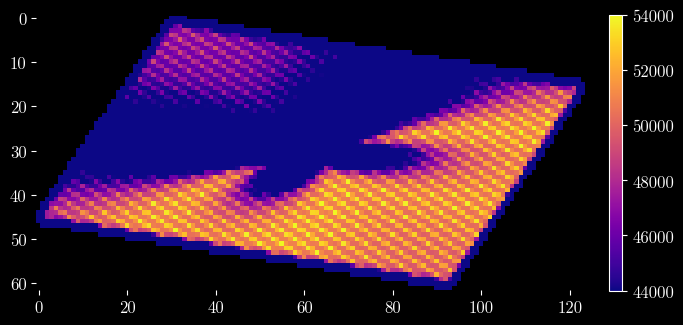

In [ ]:
# This looks like some sort of aliasing artifact
# TODO: investigate.
plt.style.use("dark_background")
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
_s = image_stack[:, :, 5, 21, 18].astype(np.float32)
mask = data[0, 1]["intensity_mask"]
im = ax.imshow(crop(_s, mask), cmap="plasma", vmin=44000, vmax=54000)
fig.colorbar(im, ax=ax, fraction=0.0235, pad=0.04)
for spine in ax.spines.values():
    spine.set_visible(False)
plt.tight_layout()
plt.show()

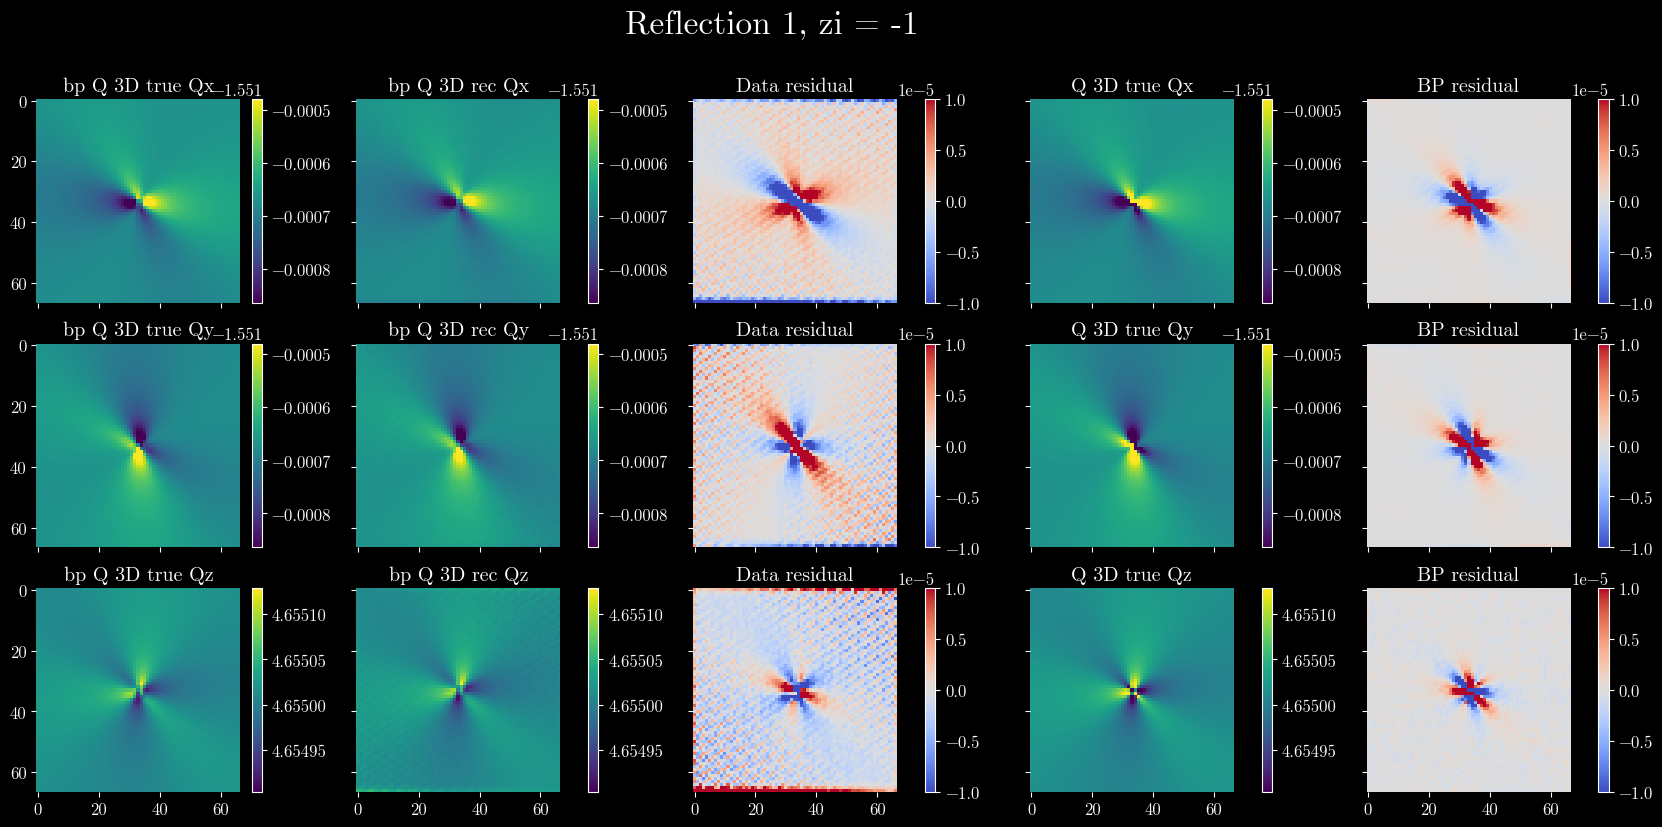

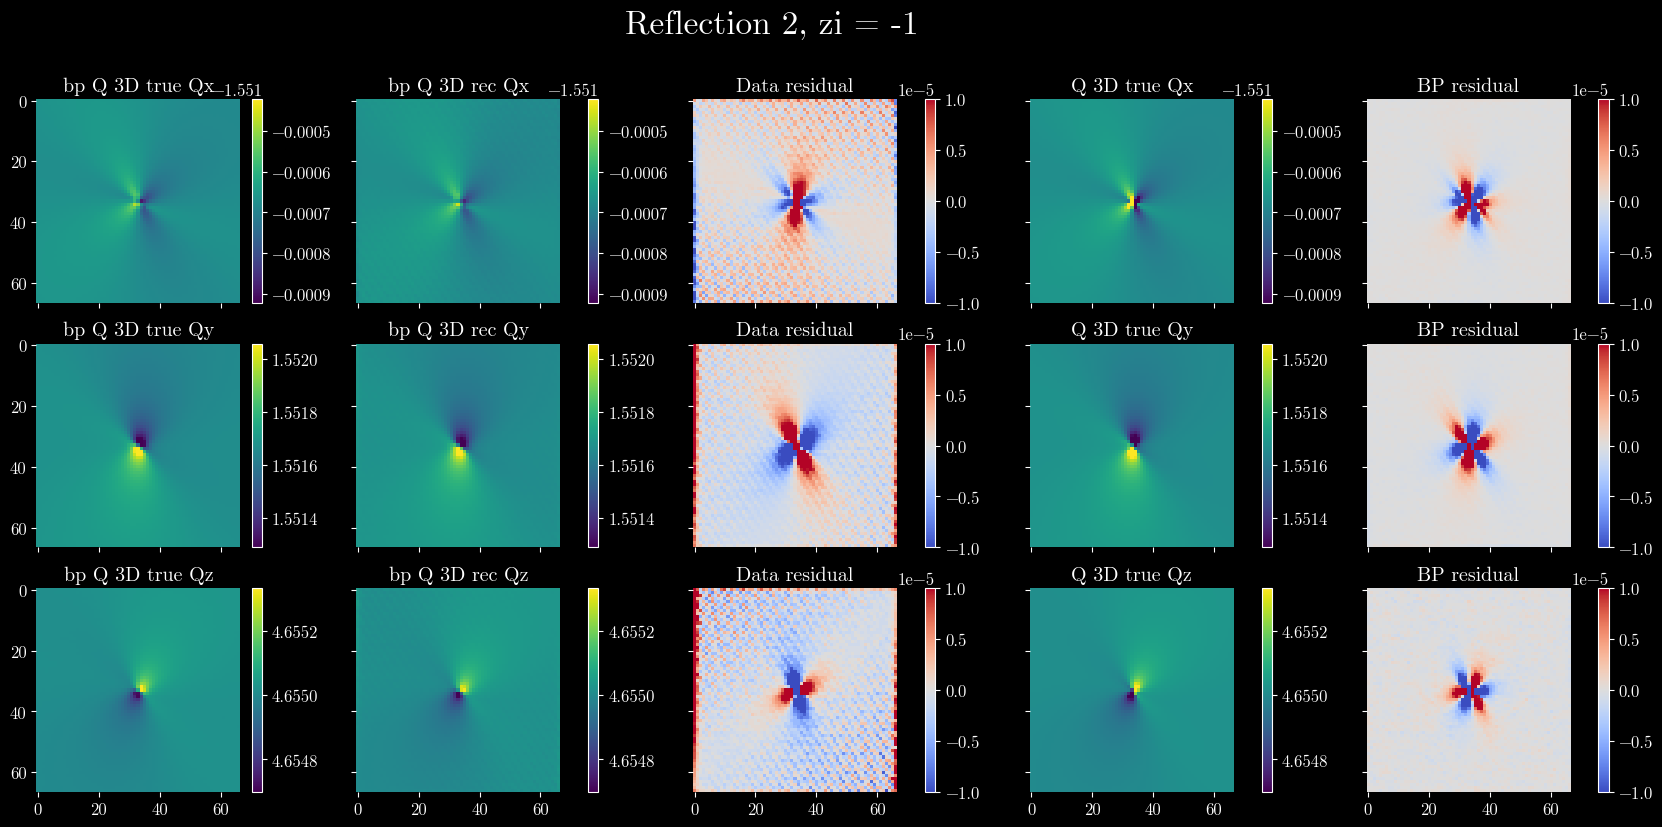

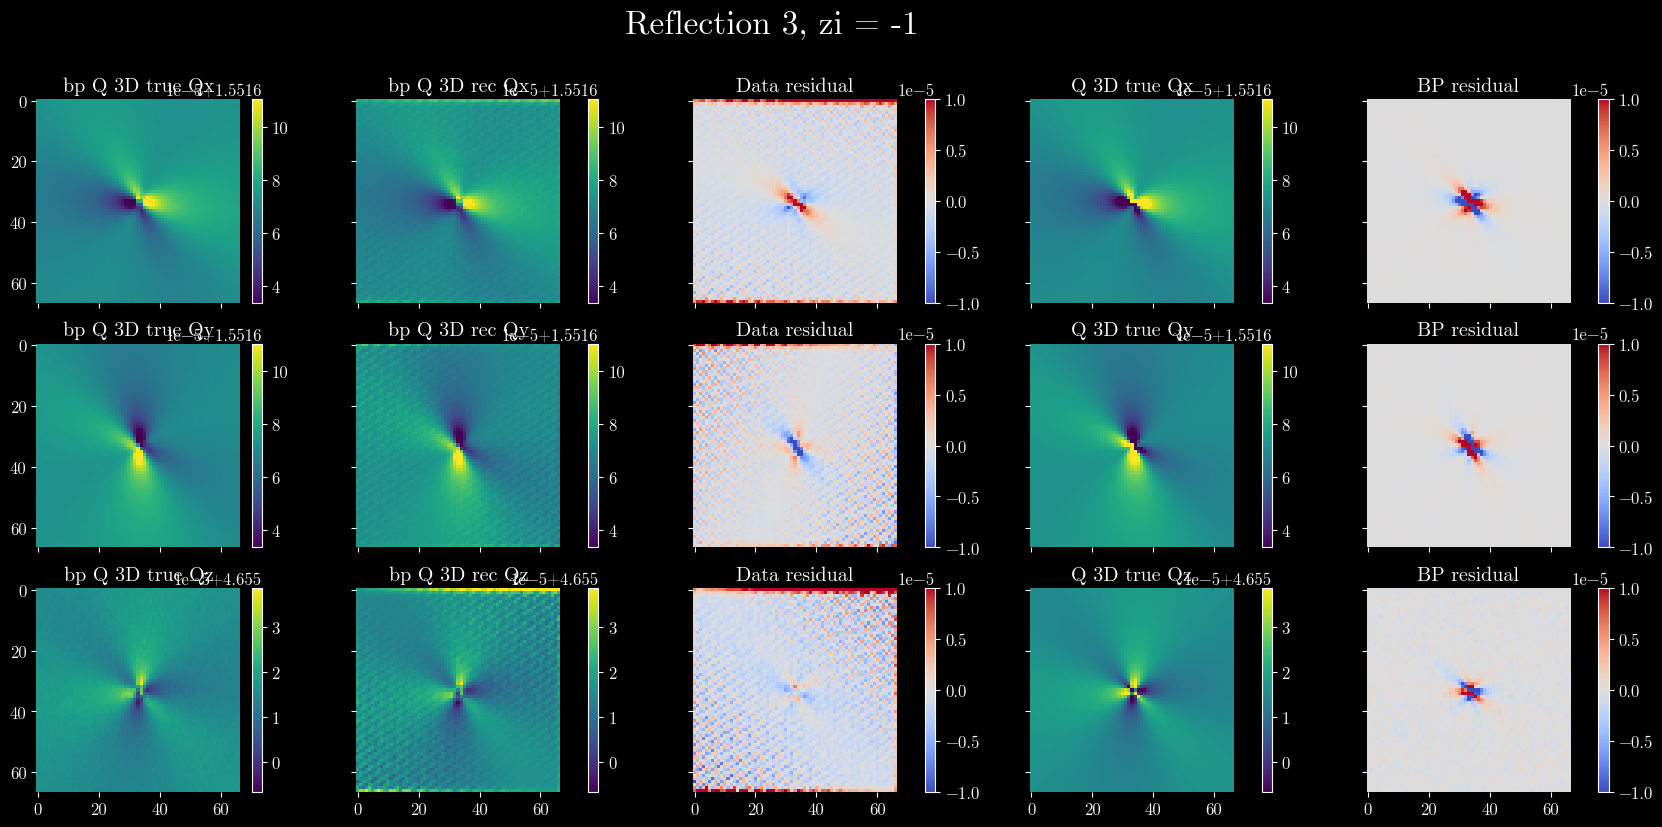

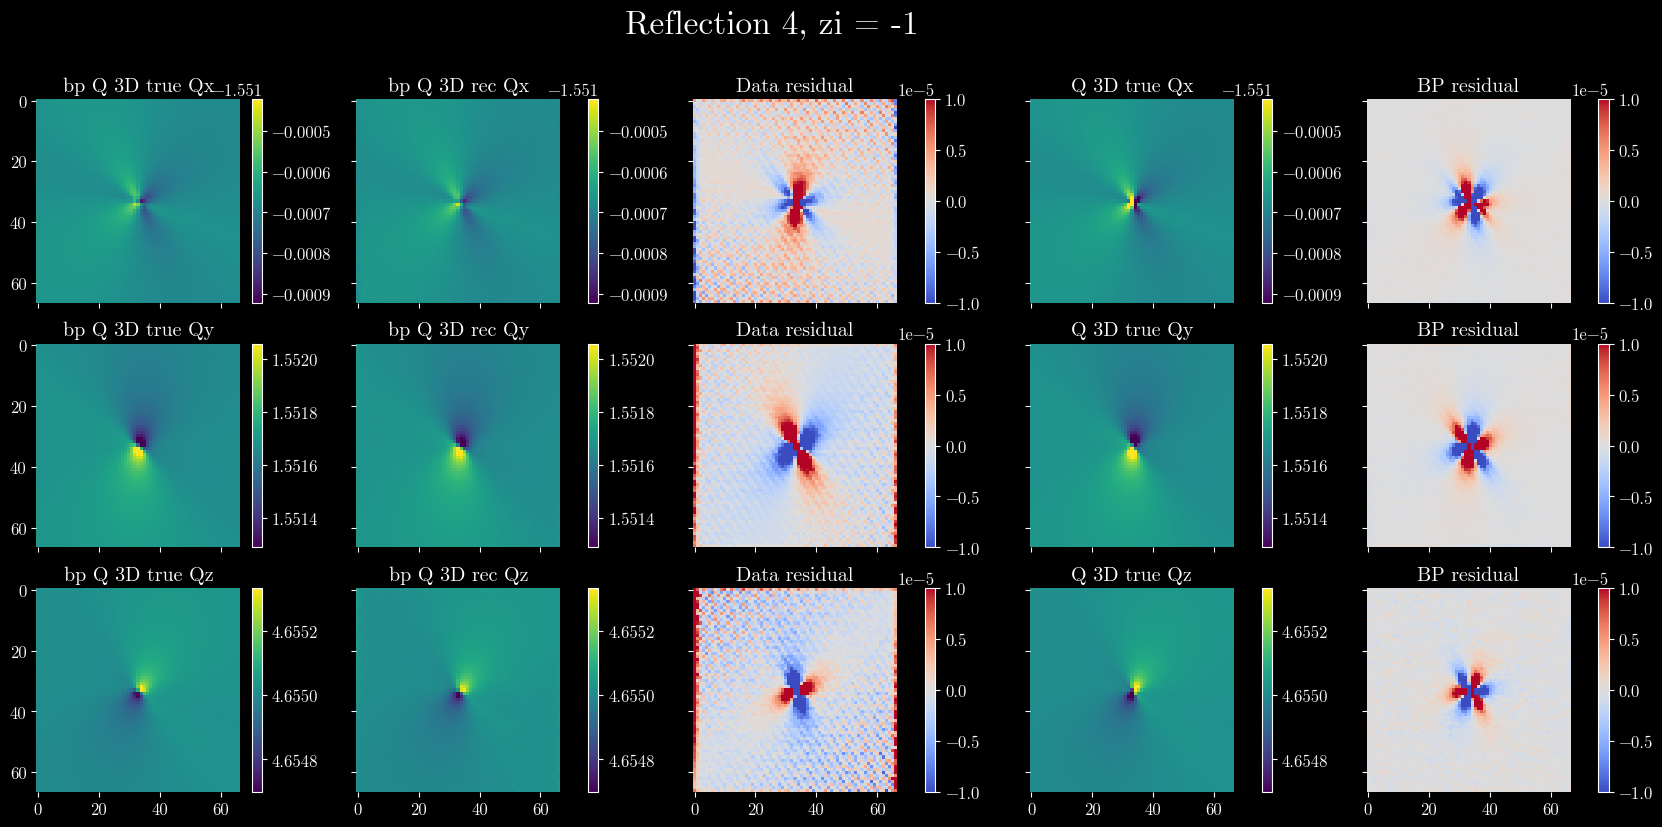

In [66]:
plt.style.use("dark_background")
zcenter = data[0, 0]["Q_sample_3D_true"].shape[2] // 2
reflection = 0


fontsize = 12  # General font size for all text
ticksize = 12  # tick size
plt.rcParams["font.size"] = fontsize
plt.rcParams["xtick.labelsize"] = ticksize
plt.rcParams["ytick.labelsize"] = ticksize

bp_key = "bp_Q_sample_3D_true"
bp_key = "bp_Q_sample_3D_rec"

zi = -1
zindex = zi + 1  # z = 0
# zindex = 2 # z +
bp_slice_ind = zcenter - zi
z_ind = bp_slice_ind

for reflection in range(4):
    fig, ax = plt.subplots(3, 5, figsize=(21, 9), sharex=True, sharey=True)

    fig.suptitle(f"Reflection {reflection + 1}, zi = {zi}", fontsize=fontsize * 2)

    for Q_component in range(3):
        vmin = np.min(
            data[reflection, zindex]["Q_sample_3D_true"][:, :, z_ind, Q_component]
        )
        vmax = np.max(
            data[reflection, zindex]["Q_sample_3D_true"][:, :, z_ind, Q_component]
        )
        dv = np.abs(vmax - vmin)

        vmin += dv / 3.0
        vmax -= dv / 3.0

        im = ax[Q_component, 0].imshow(
            data[reflection, zindex]["bp_Q_sample_3D_true"][
                :, :, bp_slice_ind, Q_component
            ],
            vmin=vmin,
            vmax=vmax,
        )
        ax[Q_component, 0].set_title(
            "bp Q 3D true" + " " + "Qx Qy Qz".split(" ")[Q_component]
        )
        fig.colorbar(im, ax=ax[Q_component, 0], fraction=0.046, pad=0.04)

        im = ax[Q_component, 1].imshow(
            data[reflection, zindex]["bp_Q_sample_3D_rec"][
                :, :, bp_slice_ind, Q_component
            ],
            vmin=vmin,
            vmax=vmax,
        )
        ax[Q_component, 1].set_title(
            "bp Q 3D rec" + " " + "Qx Qy Qz".split(" ")[Q_component]
        )
        fig.colorbar(im, ax=ax[Q_component, 1], fraction=0.046, pad=0.1)

        res = data[reflection, zindex]["bp_Q_sample_3D_rec"][
            :, :, z_ind, Q_component
        ].astype(float) - data[reflection, zindex]["bp_Q_sample_3D_true"][
            :, :, bp_slice_ind, Q_component
        ].astype(float)
        # print("Qx Qy Qz".split(" ")[Q_component], np.sum(res * res) * 1e6)
        im = ax[Q_component, 2].imshow(res, vmin=-1e-5, vmax=1e-5, cmap="coolwarm")
        ax[Q_component, 2].set_title("Data residual")
        fig.colorbar(im, ax=ax[Q_component, 2], fraction=0.046, pad=0.1)

        im = ax[Q_component, 3].imshow(
            data[reflection, zindex]["Q_sample_3D_true"][:, :, z_ind, Q_component],
            vmin=vmin,
            vmax=vmax,
        )
        ax[Q_component, 3].set_title(
            "Q 3D true" + " " + "Qx Qy Qz".split(" ")[Q_component]
        )
        fig.colorbar(im, ax=ax[Q_component, 3], fraction=0.046, pad=0.1)

        res_inh = data[reflection, zindex]["Q_sample_3D_true"][
            :, :, z_ind, Q_component
        ].astype(float) - data[reflection, zindex]["bp_Q_sample_3D_true"][
            :, :, bp_slice_ind, Q_component
        ].astype(float)
        # print("Qx Qy Qz".split(" ")[Q_component], np.sum(res_inh * res_inh) * 1e6)
        im = ax[Q_component, 4].imshow(res_inh, vmin=-1e-5, vmax=1e-5, cmap="coolwarm")
        ax[Q_component, 4].set_title("BP residual")
        fig.colorbar(im, ax=ax[Q_component, 4], fraction=0.046, pad=0.1)
        for a in ax.flatten():
            for spine in a.spines.values():
                spine.set_visible(False)
    plt.show()

In [ ]:
# unpack

diffraction_vectors_rec = [
    reflection[zindex]["bp_Q_sample_3D_rec"] for reflection in data
]

In [143]:
# Run the reconstructor to get back the deformation gradient tensor field
defgrads = []
betas = []
betas_true = []


zcenter = data[0, 0]["Q_sample_3D_true"].shape[2] // 2

for zi in [-1, 0, 1]:
    zindex = zi + 1
    bp_slice_ind = zcenter - zi

    diffraction_vectors_rec = [
        reflection[zindex]["bp_Q_sample_3D_rec"] for reflection in data
    ]
    hkl = [reflection[zindex]["hkl"] for reflection in data]
    UB_reference = data[0, zindex]["U_0"] @ data[0, zindex]["B_0"]

    defgrad = darkmod.reconstruct.deformation(
        [d[:, :, bp_slice_ind, :] for d in diffraction_vectors_rec],
        hkl,
        UB_reference,
    )
    defgrads.append(defgrad.copy())

    mask = ~(np.sum(defgrad, axis=(-1, -2)) == 0)
    beta = defgrad.copy()

    beta_true_3D = data[0, zindex]["defgrad"]
    for i in range(3):
        beta[..., i, i] -= 1
        beta_true_3D[..., i, i] -= 1

    betas.append(beta.copy())
    betas_true.append(beta_true_3D.copy())


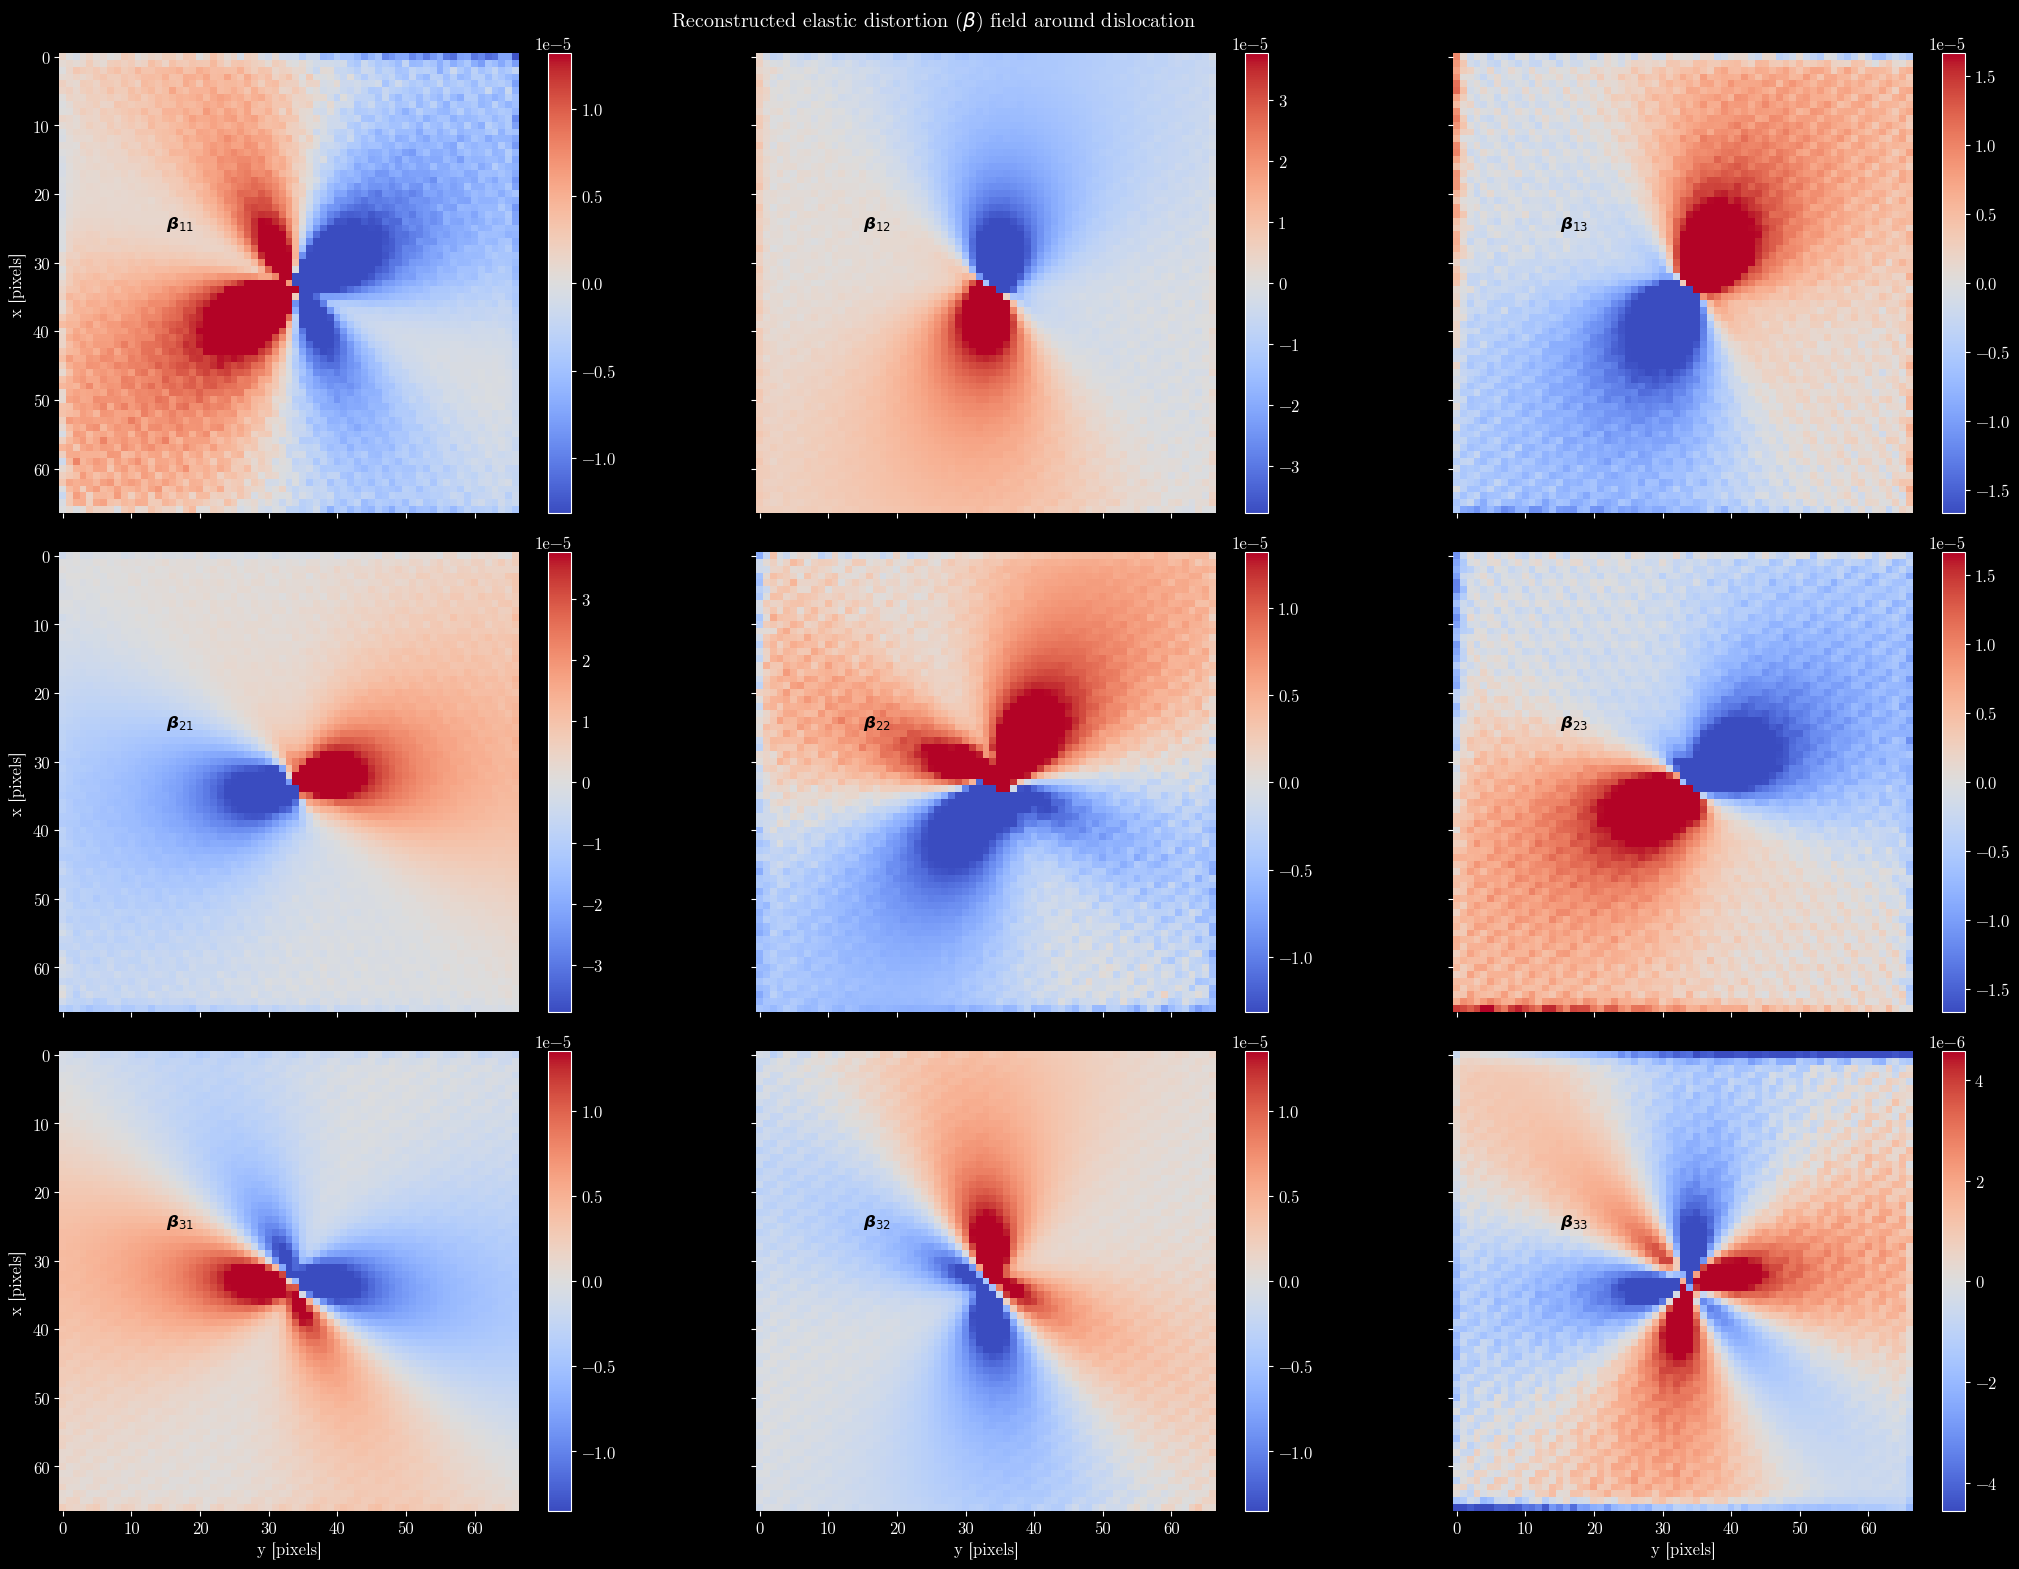

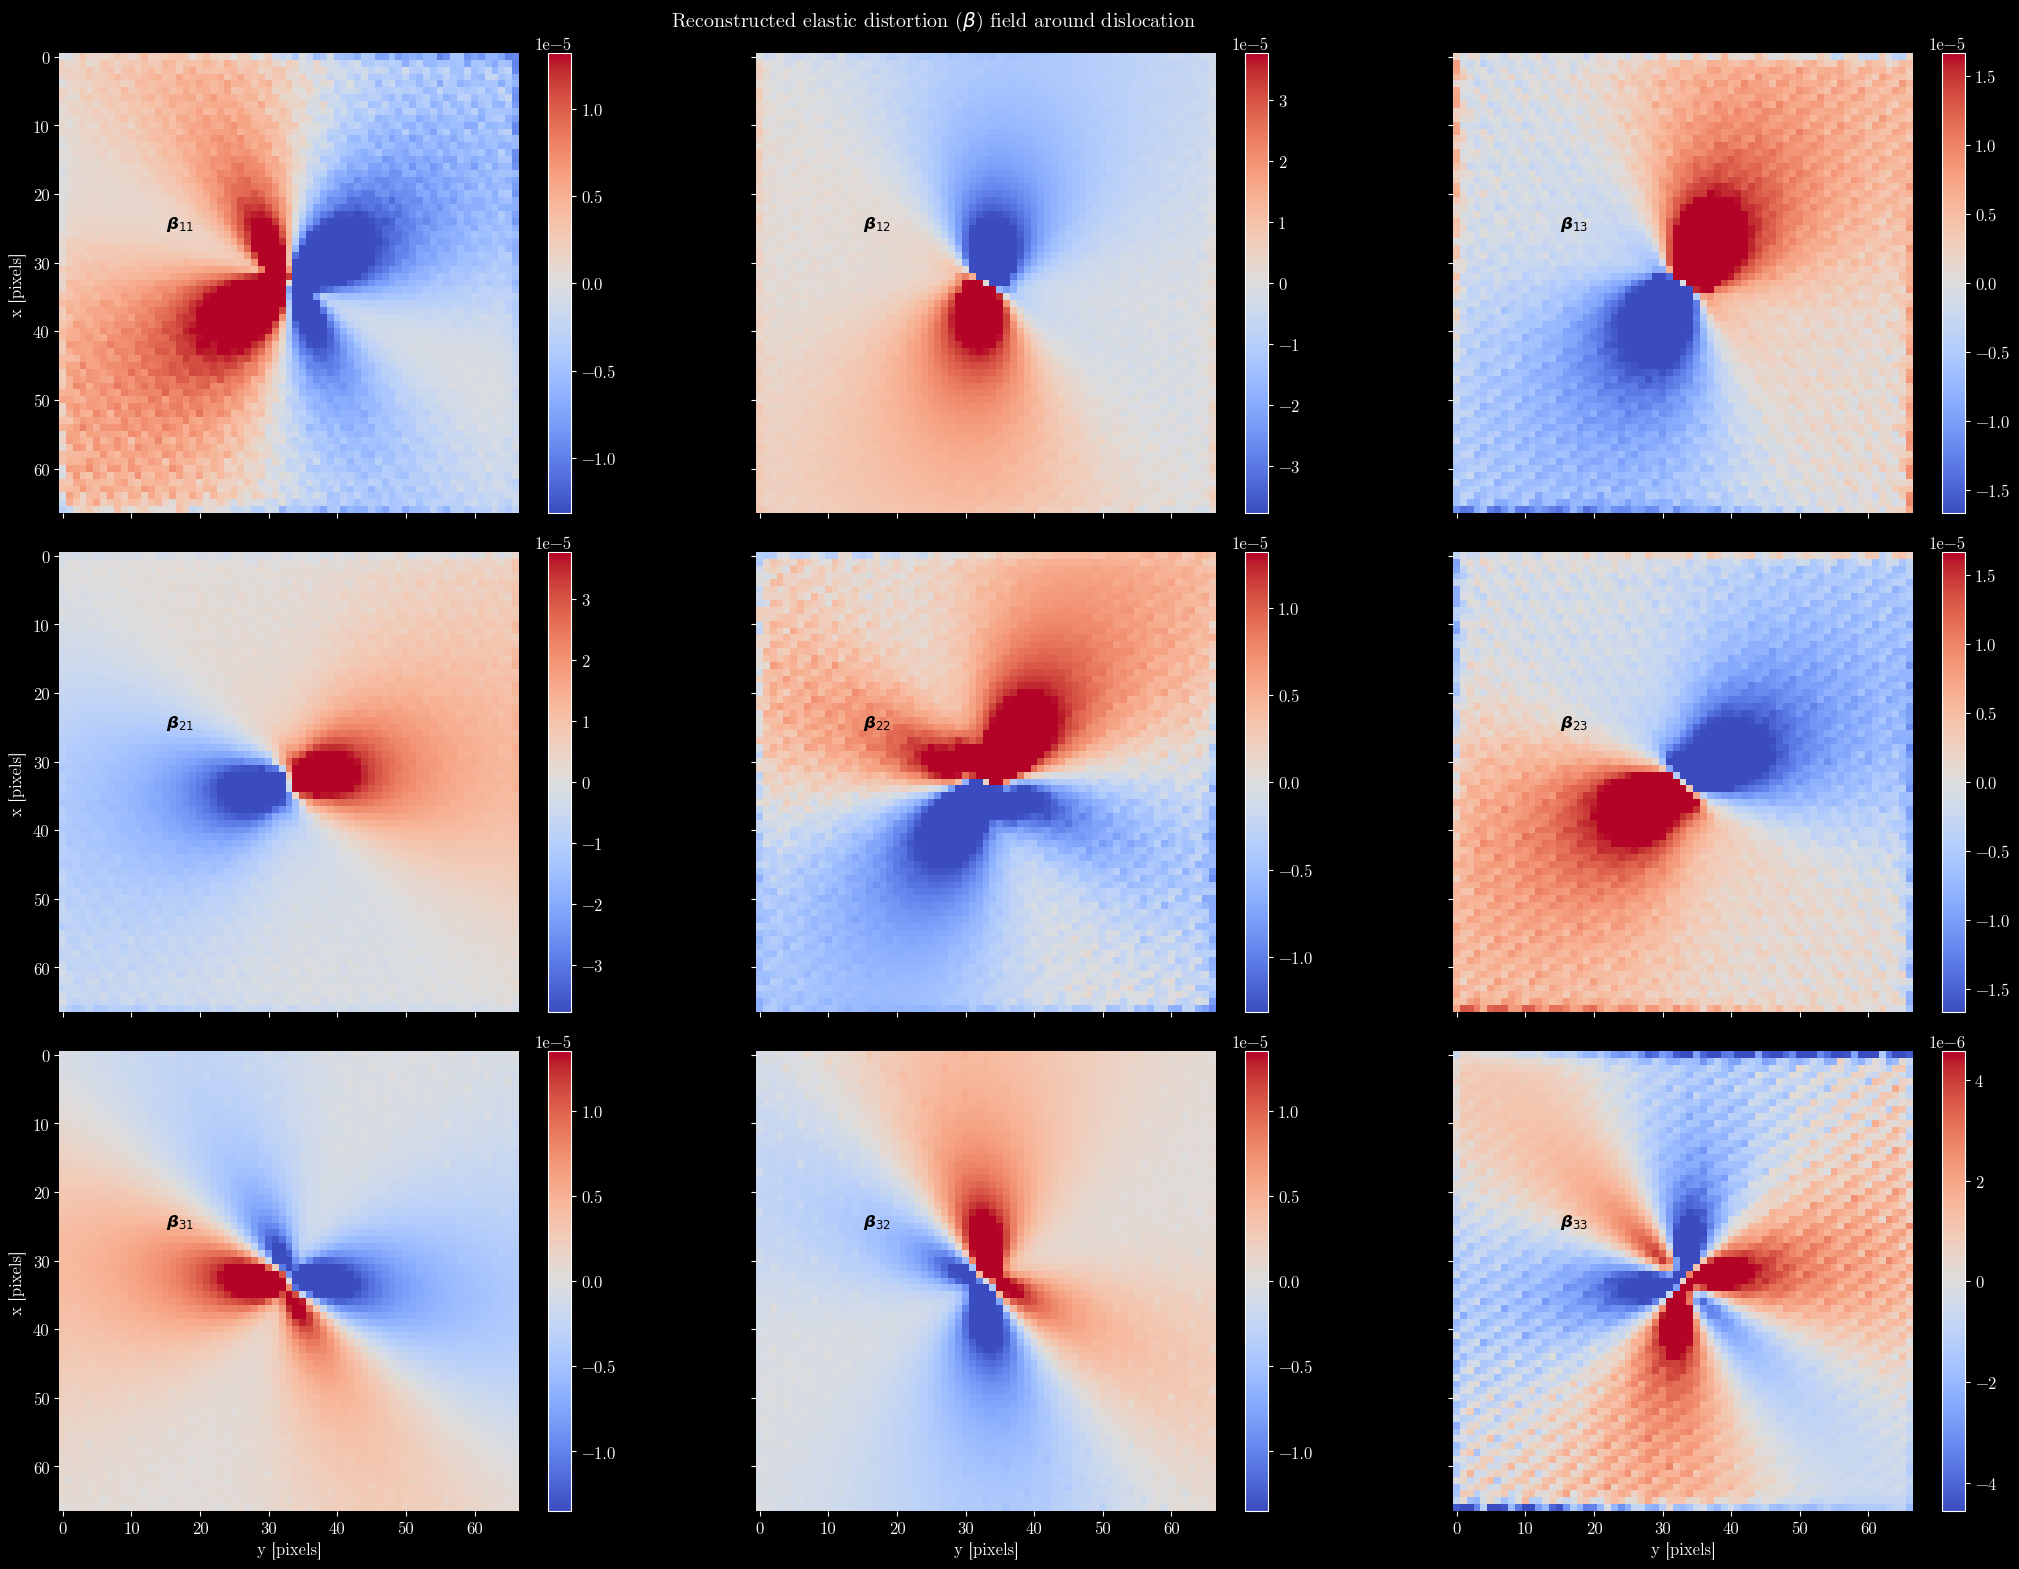

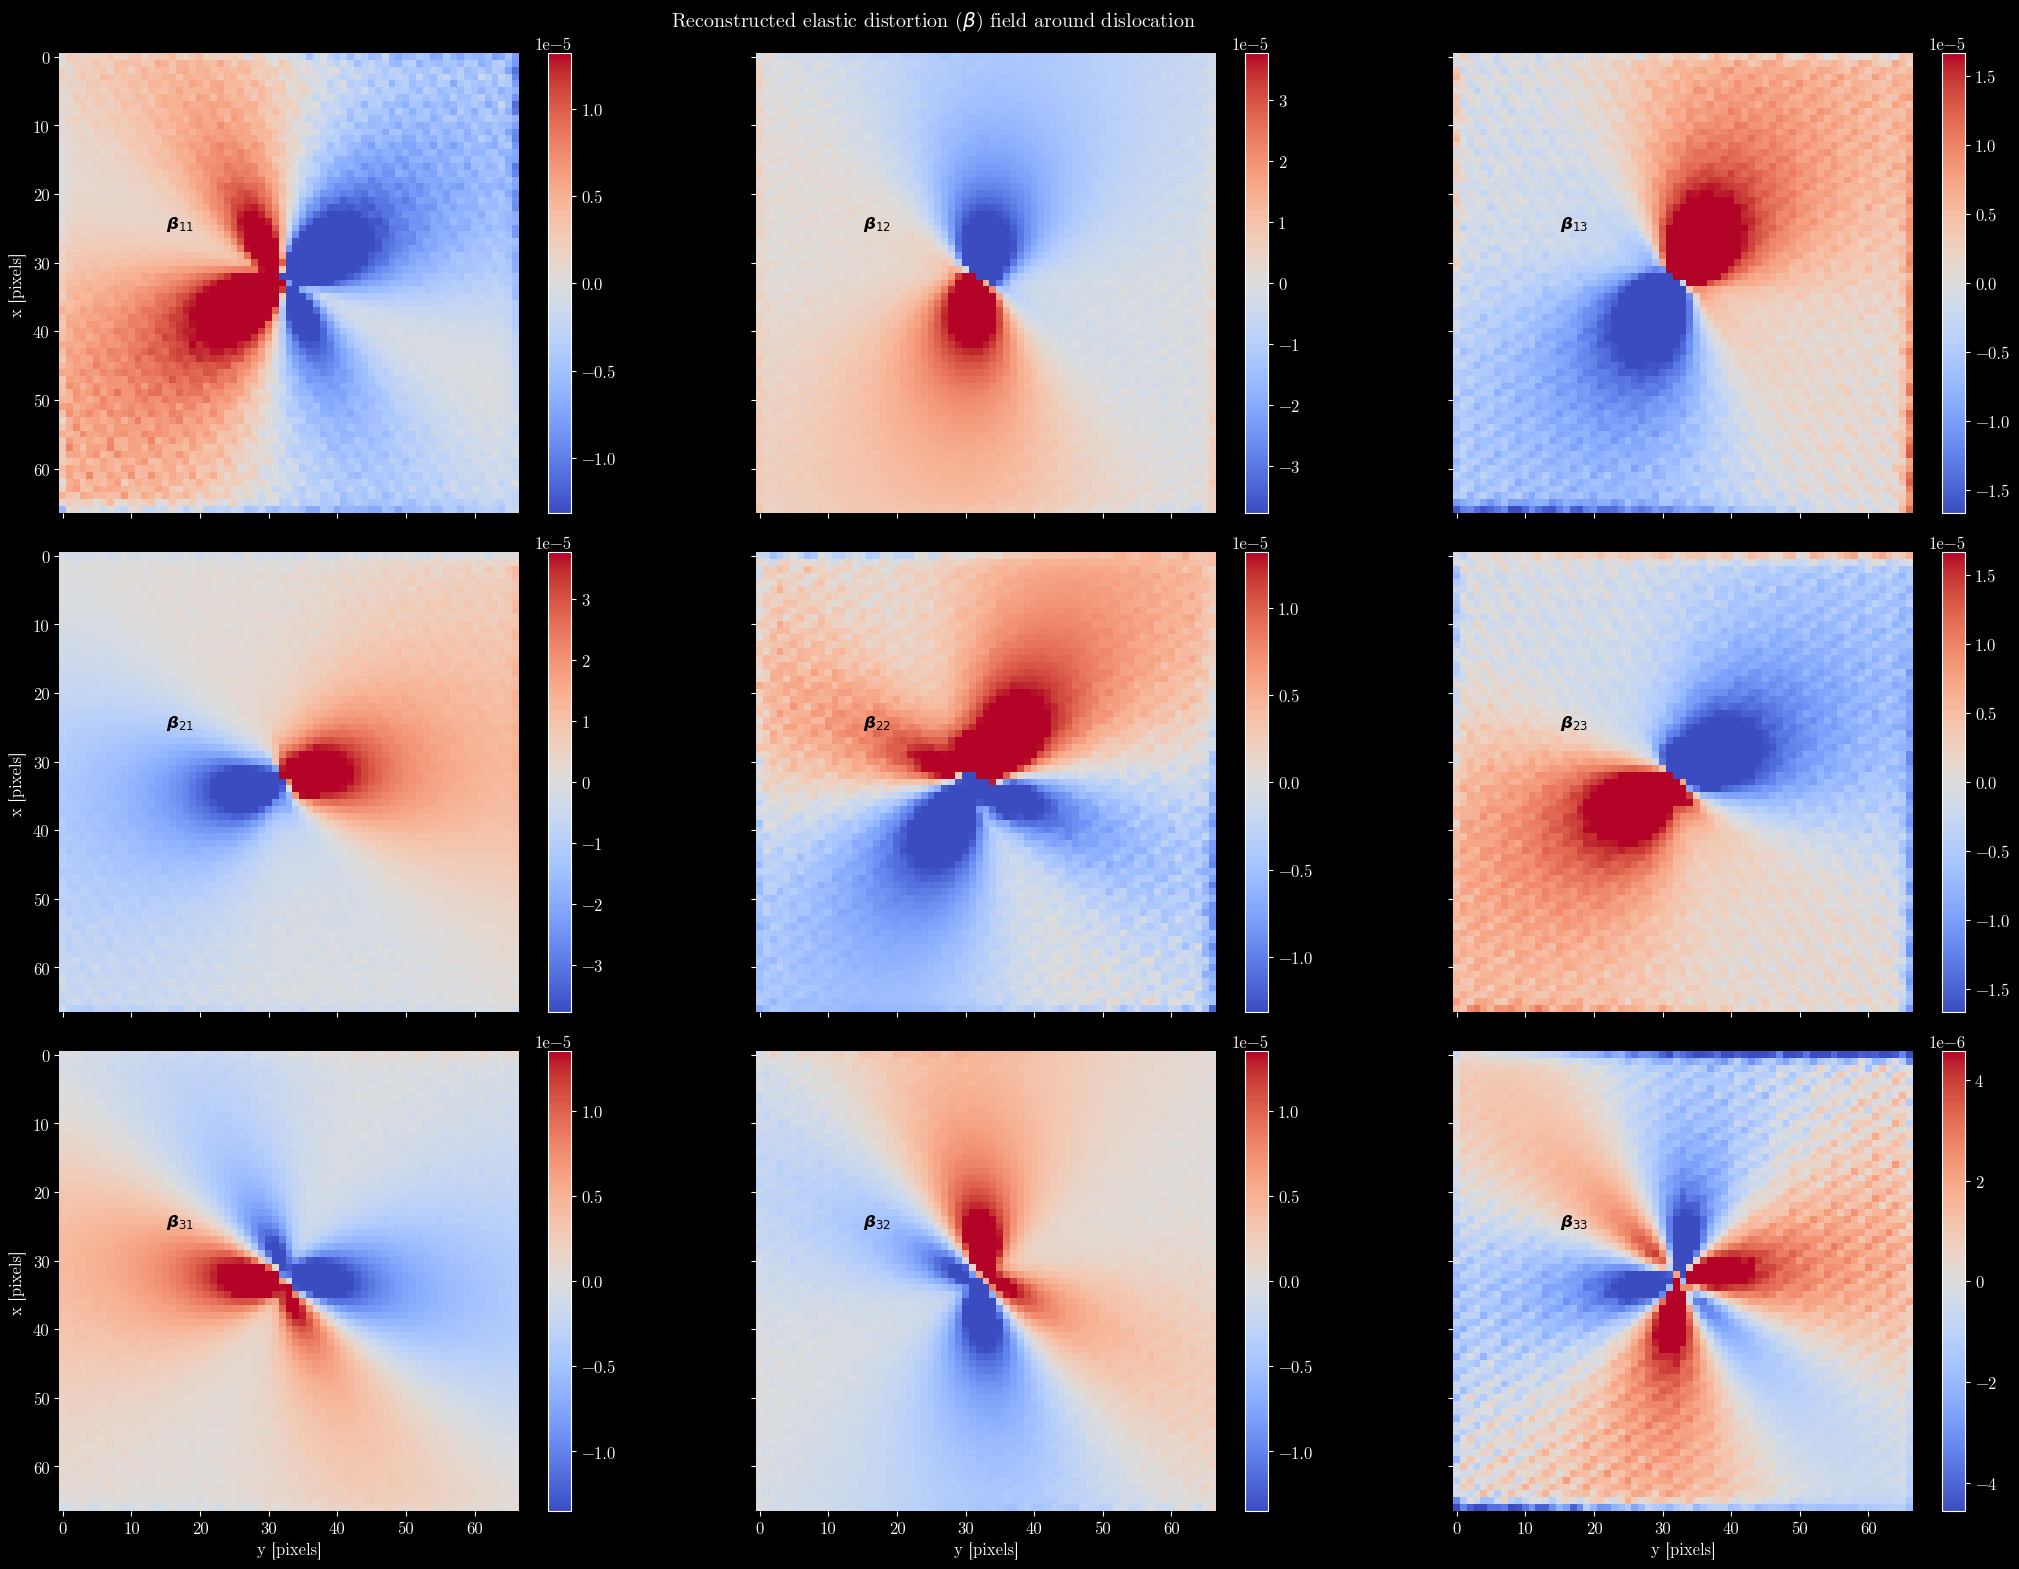

In [92]:
for k in range(3):
    plt.style.use("dark_background")
    fig, ax = plt.subplots(3, 3, figsize=(22, 16), sharex=True, sharey=True)
    fig.suptitle("Reconstructed elastic distortion ($\\beta$) field around dislocation")
    for i in range(3):
        for j in range(3):
            mask = ~(np.sum(defgrads[k], axis=(-1, -2)) == 0)
            _s = crop(betas[k][:, :, i, j], mask)

            vmax = np.nanmax(np.abs(betas_true[k][:, :, 4, i, j])) * 0.1
            vmin = -vmax
            im = ax[i, j].imshow(
                _s,
                vmin=vmin,
                vmax=vmax,
                cmap="coolwarm",
            )
            ax[i, j].annotate(
                r"$\boldsymbol{\beta}_{" + str(i + 1) + str(j + 1) + r"}$",
                (15, 25),
                c="black",
            )
            fig.colorbar(im, ax=ax[i, j], fraction=0.046, pad=0.04)
            if i == 2:
                ax[i, j].set_xlabel("y [pixels]")
            if j == 0:
                ax[i, j].set_ylabel("x [pixels]")
    plt.tight_layout()
    for a in ax.flatten():
        for spine in a.spines.values():
            spine.set_visible(False)
plt.show()

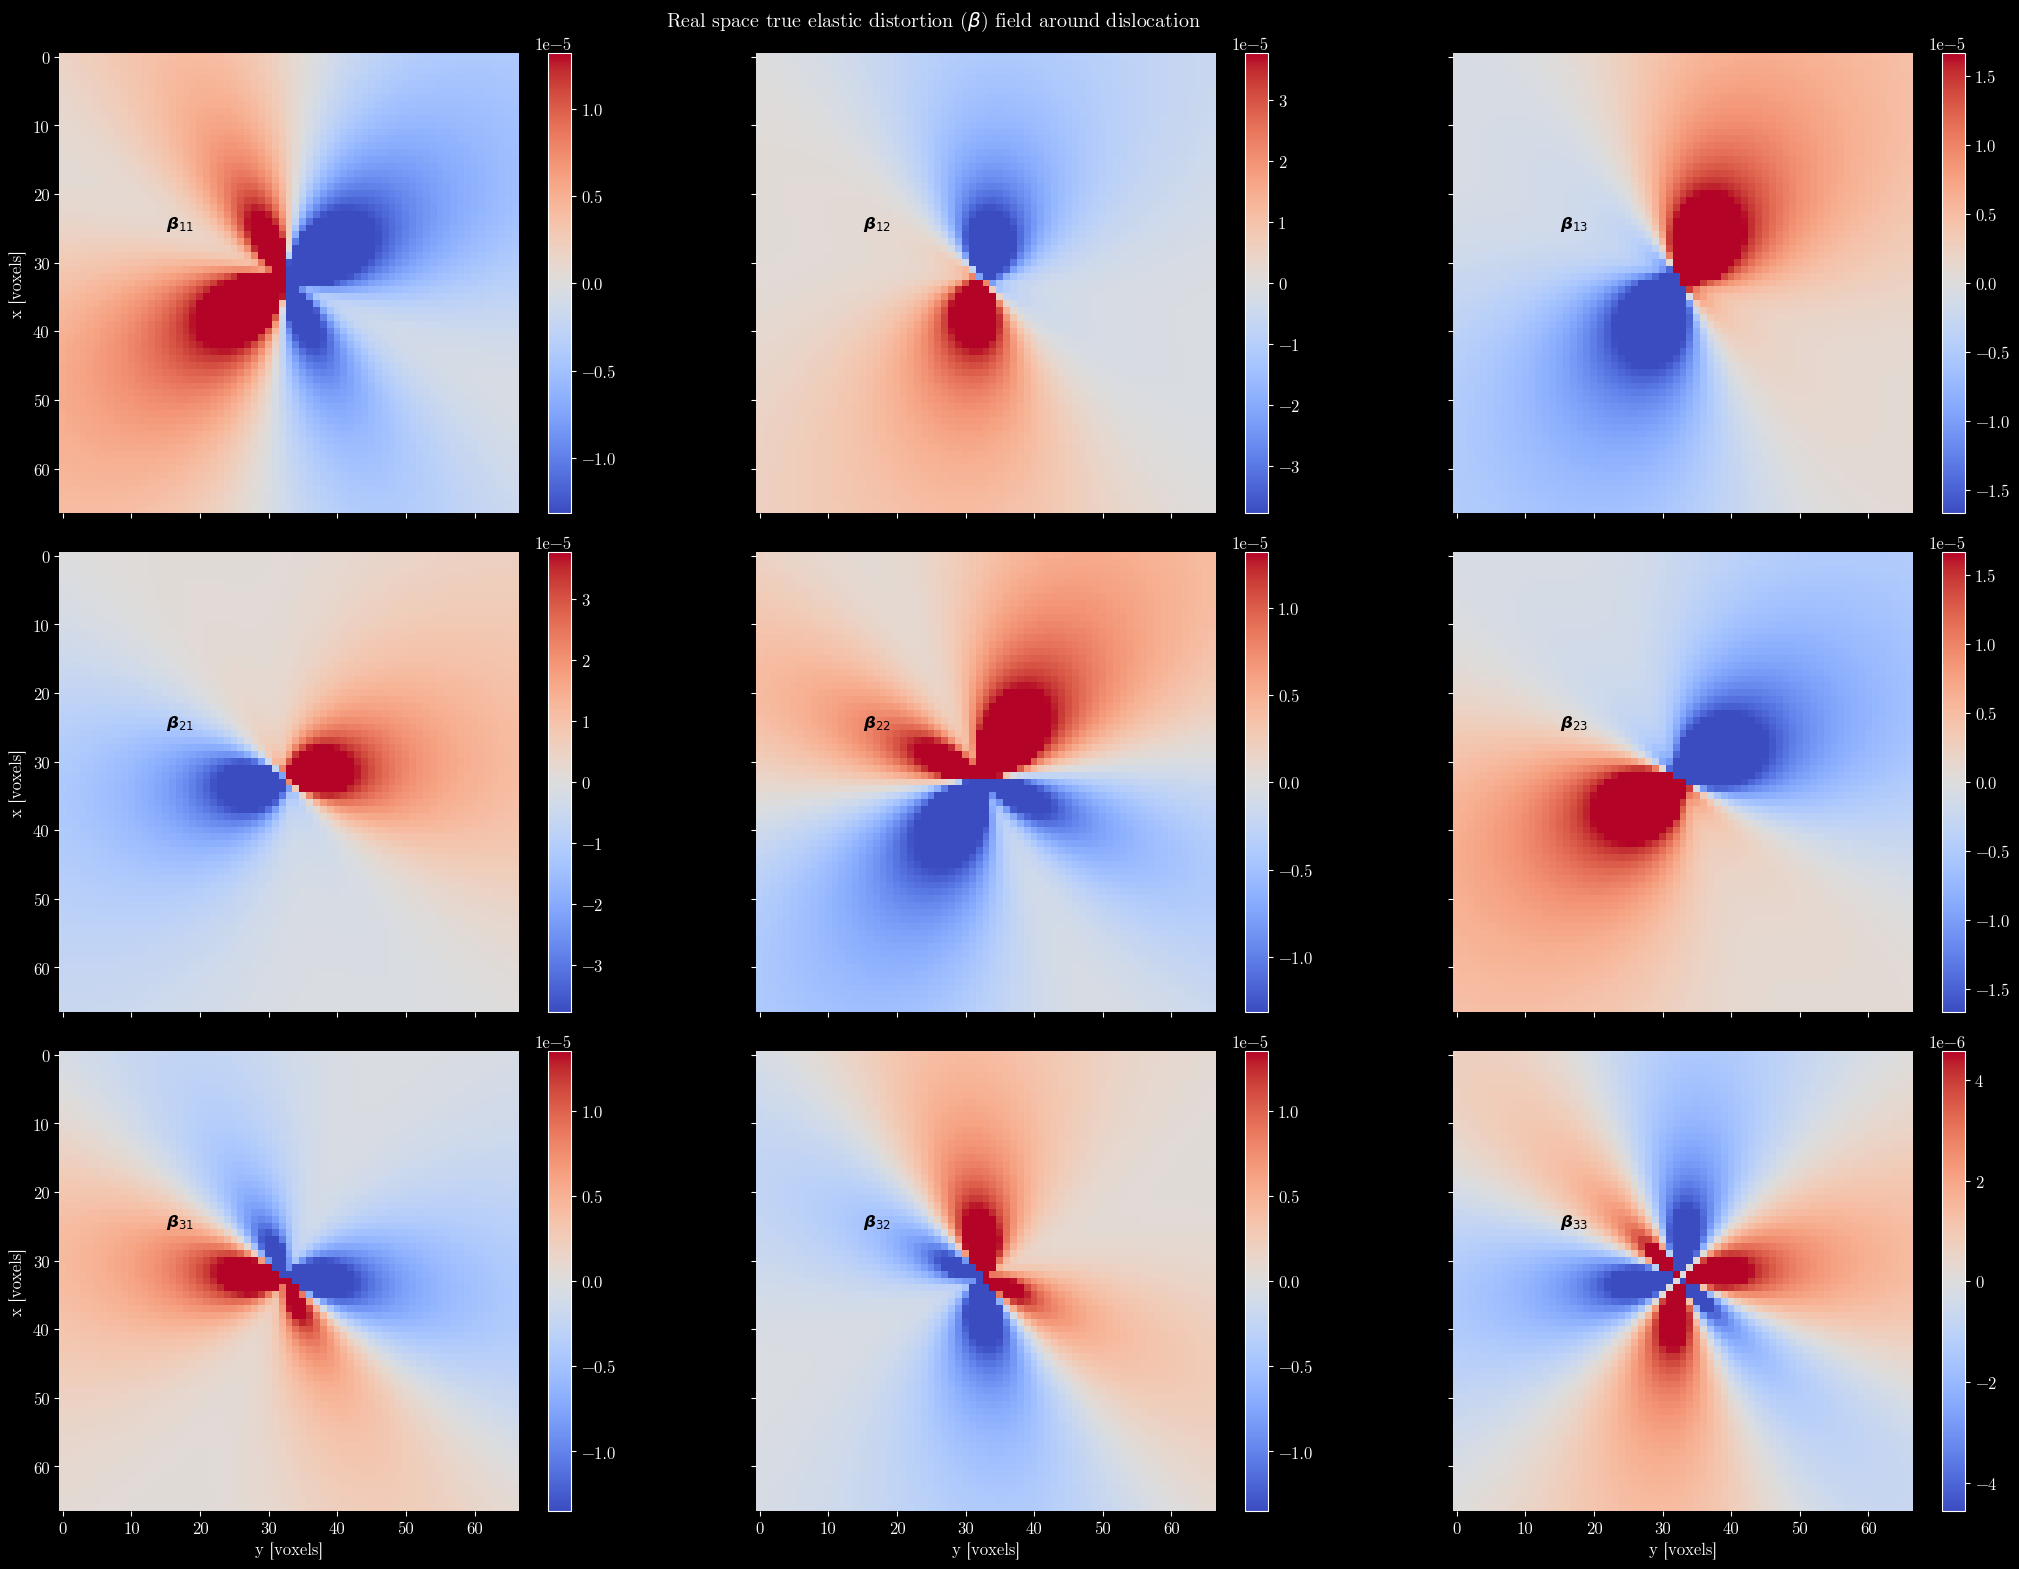

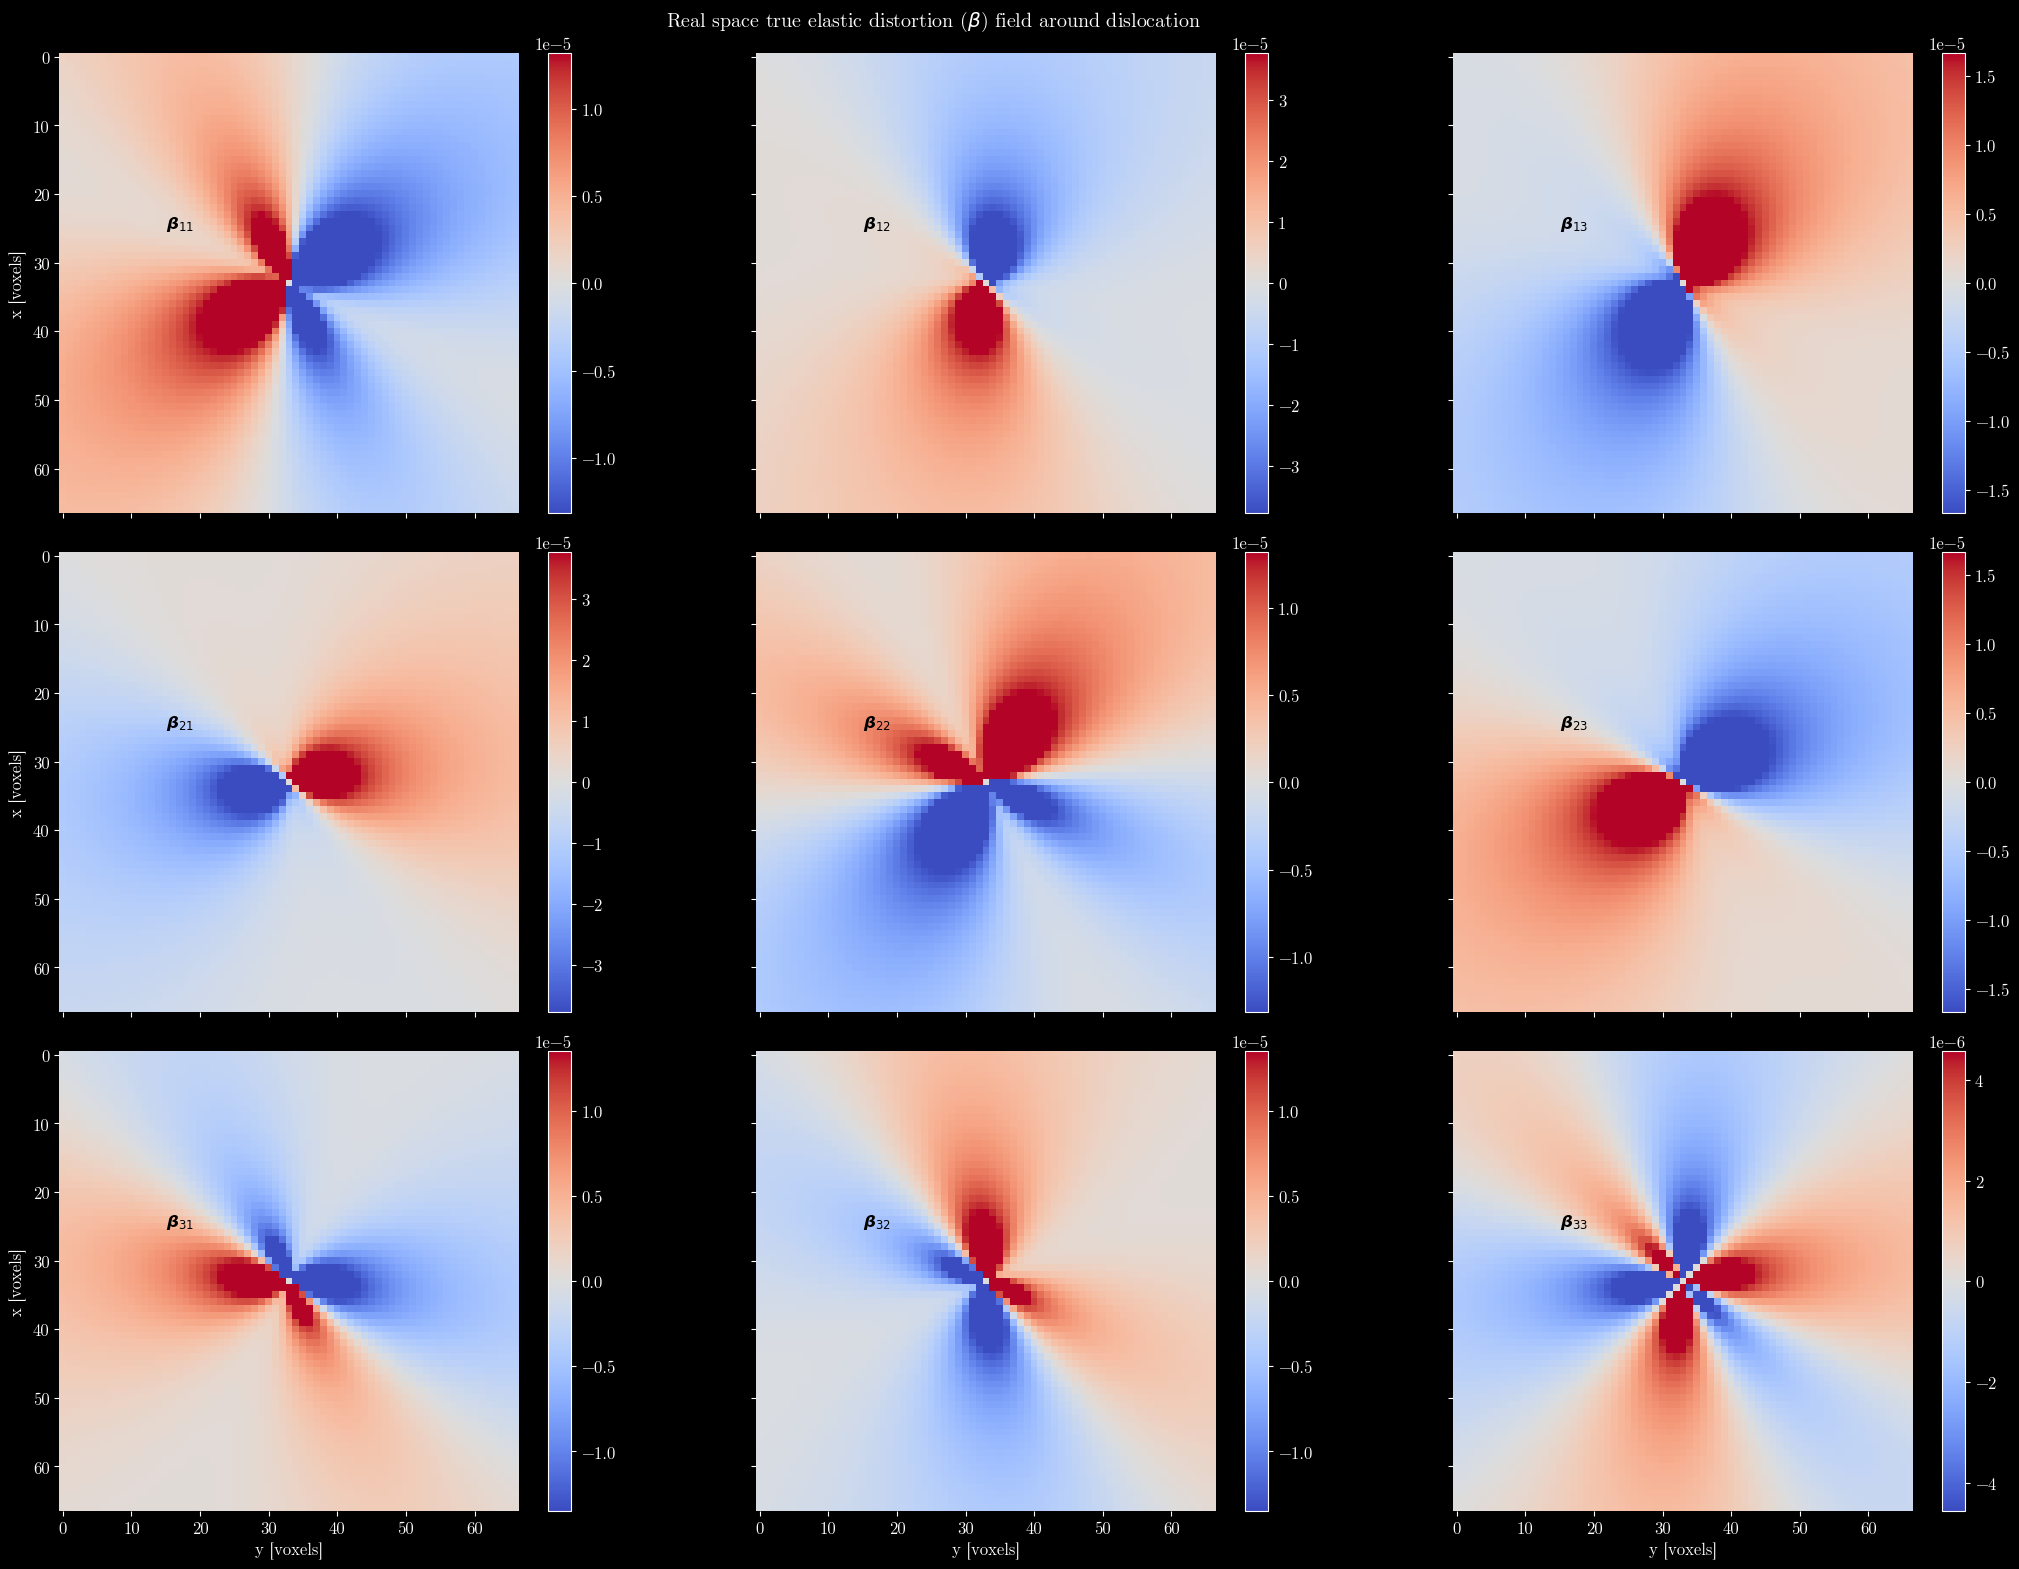

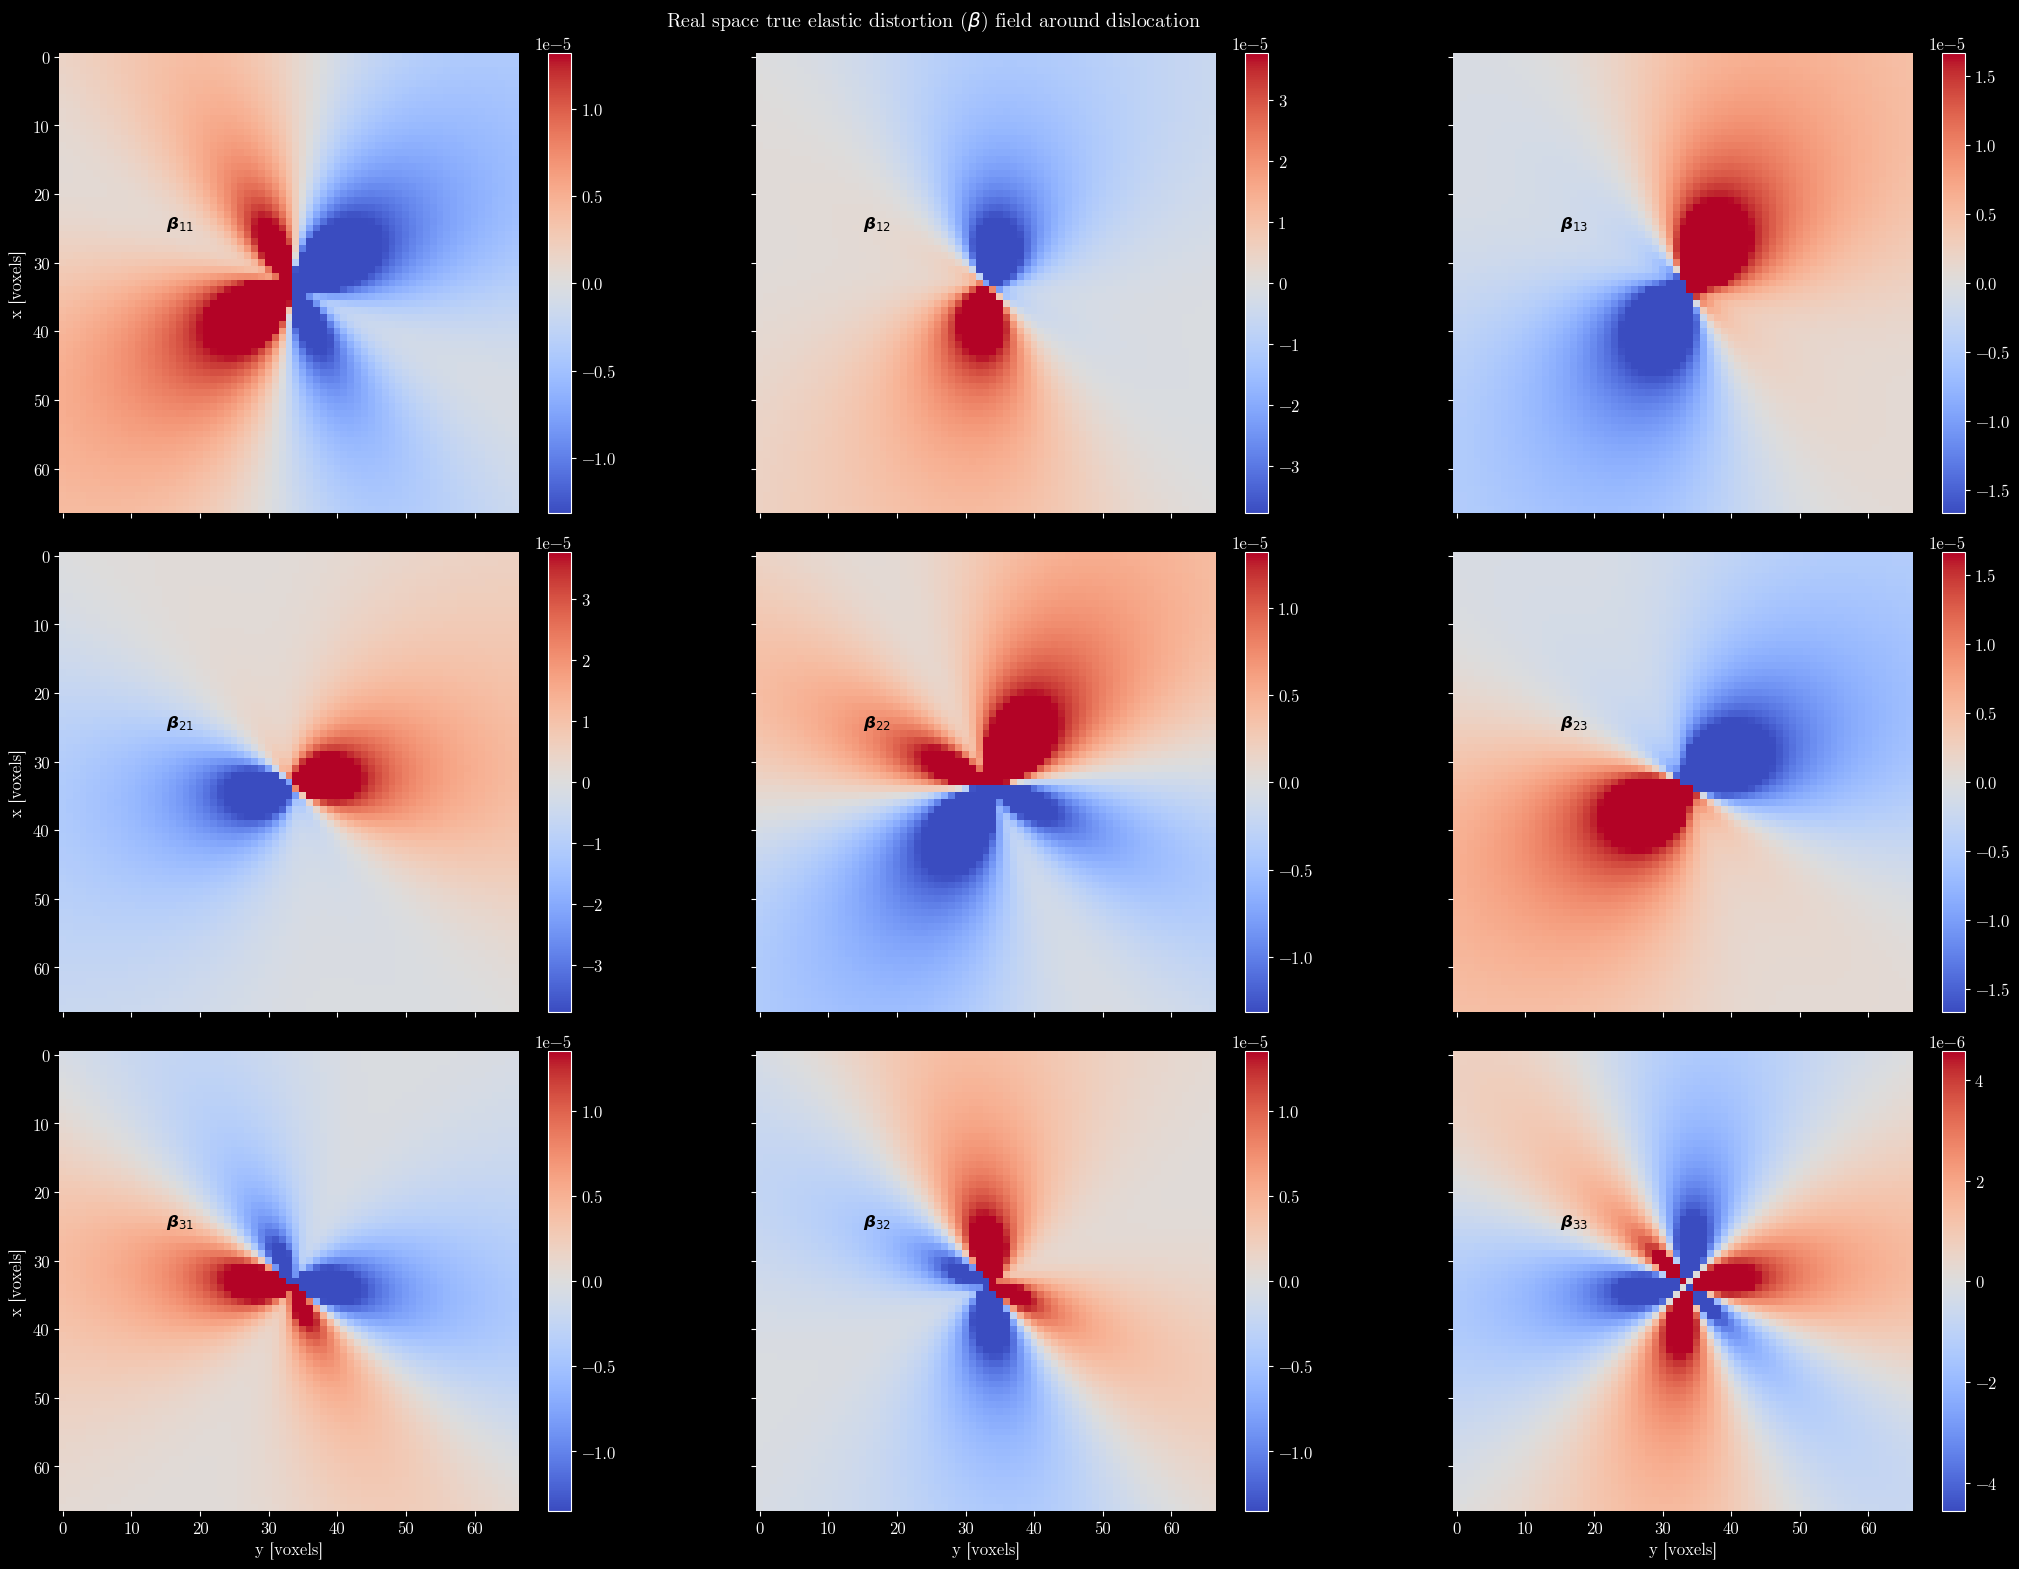

In [ ]:
plt.style.use("dark_background")
for k in [3, 4, 5]:
    fig, ax = plt.subplots(3, 3, figsize=(22, 16), sharex=True, sharey=True)
    fig.suptitle(
        "Real space true elastic distortion ($\\beta$) field around dislocation"
    )
    for i in range(3):
        for j in range(3):
            # _s = crop(beta[:, :, i, j], mask)
            _s = beta_true_3D[:, :, k, i, j]
            vmax = np.nanmax(np.abs(beta_true_3D[:, :, 4, i, j])) * 0.1
            vmin = -vmax
            im = ax[i, j].imshow(
                _s,
                vmin=vmin,
                vmax=vmax,
                cmap="coolwarm",
            )
            ax[i, j].annotate(
                r"$\boldsymbol{\beta}_{" + str(i + 1) + str(j + 1) + r"}$",
                (15, 25),
                c="black",
            )
            fig.colorbar(im, ax=ax[i, j], fraction=0.046, pad=0.04)
            if i == 2:
                ax[i, j].set_xlabel("y [voxels]")
            if j == 0:
                ax[i, j].set_ylabel("x [voxels]")
    plt.tight_layout()
    for a in ax.flatten():
        for spine in a.spines.values():
            spine.set_visible(False)


In [ ]:
dx = dy = dz = data[0, zindex]["voxel_size"]


elasticity_matrix = np.array(
    [
        [104, 73, 73, 0, 0, 0],
        [73, 104, 73, 0, 0, 0],
        [73, 73, 104, 0, 0, 0],
        [0, 0, 0, 32, 0, 0],
        [0, 0, 0, 0, 32, 0],
        [0, 0, 0, 0, 0, 32],
    ]
)  # units of GPa

B_0 = data[0, zindex]["B_0"]
U_0 = data[0, zindex]["U_0"]
C_c = np.linalg.inv(B_0).T
E = np.column_stack((C_c[:, 0], np.cross(C_c[:, 2], C_c[:, 0]), C_c[:, 2]))
E /= np.linalg.norm(E, axis=0)

R = U_0 @ E

stress = [
    beta_to_stress(betas[1][..., np.newaxis, :, :], elasticity_matrix, rotation=R)
    for i in range(3)
]

_b = np.concatenate(stress, axis=2)
residual = divergence(_b, (dx, dy, dz))

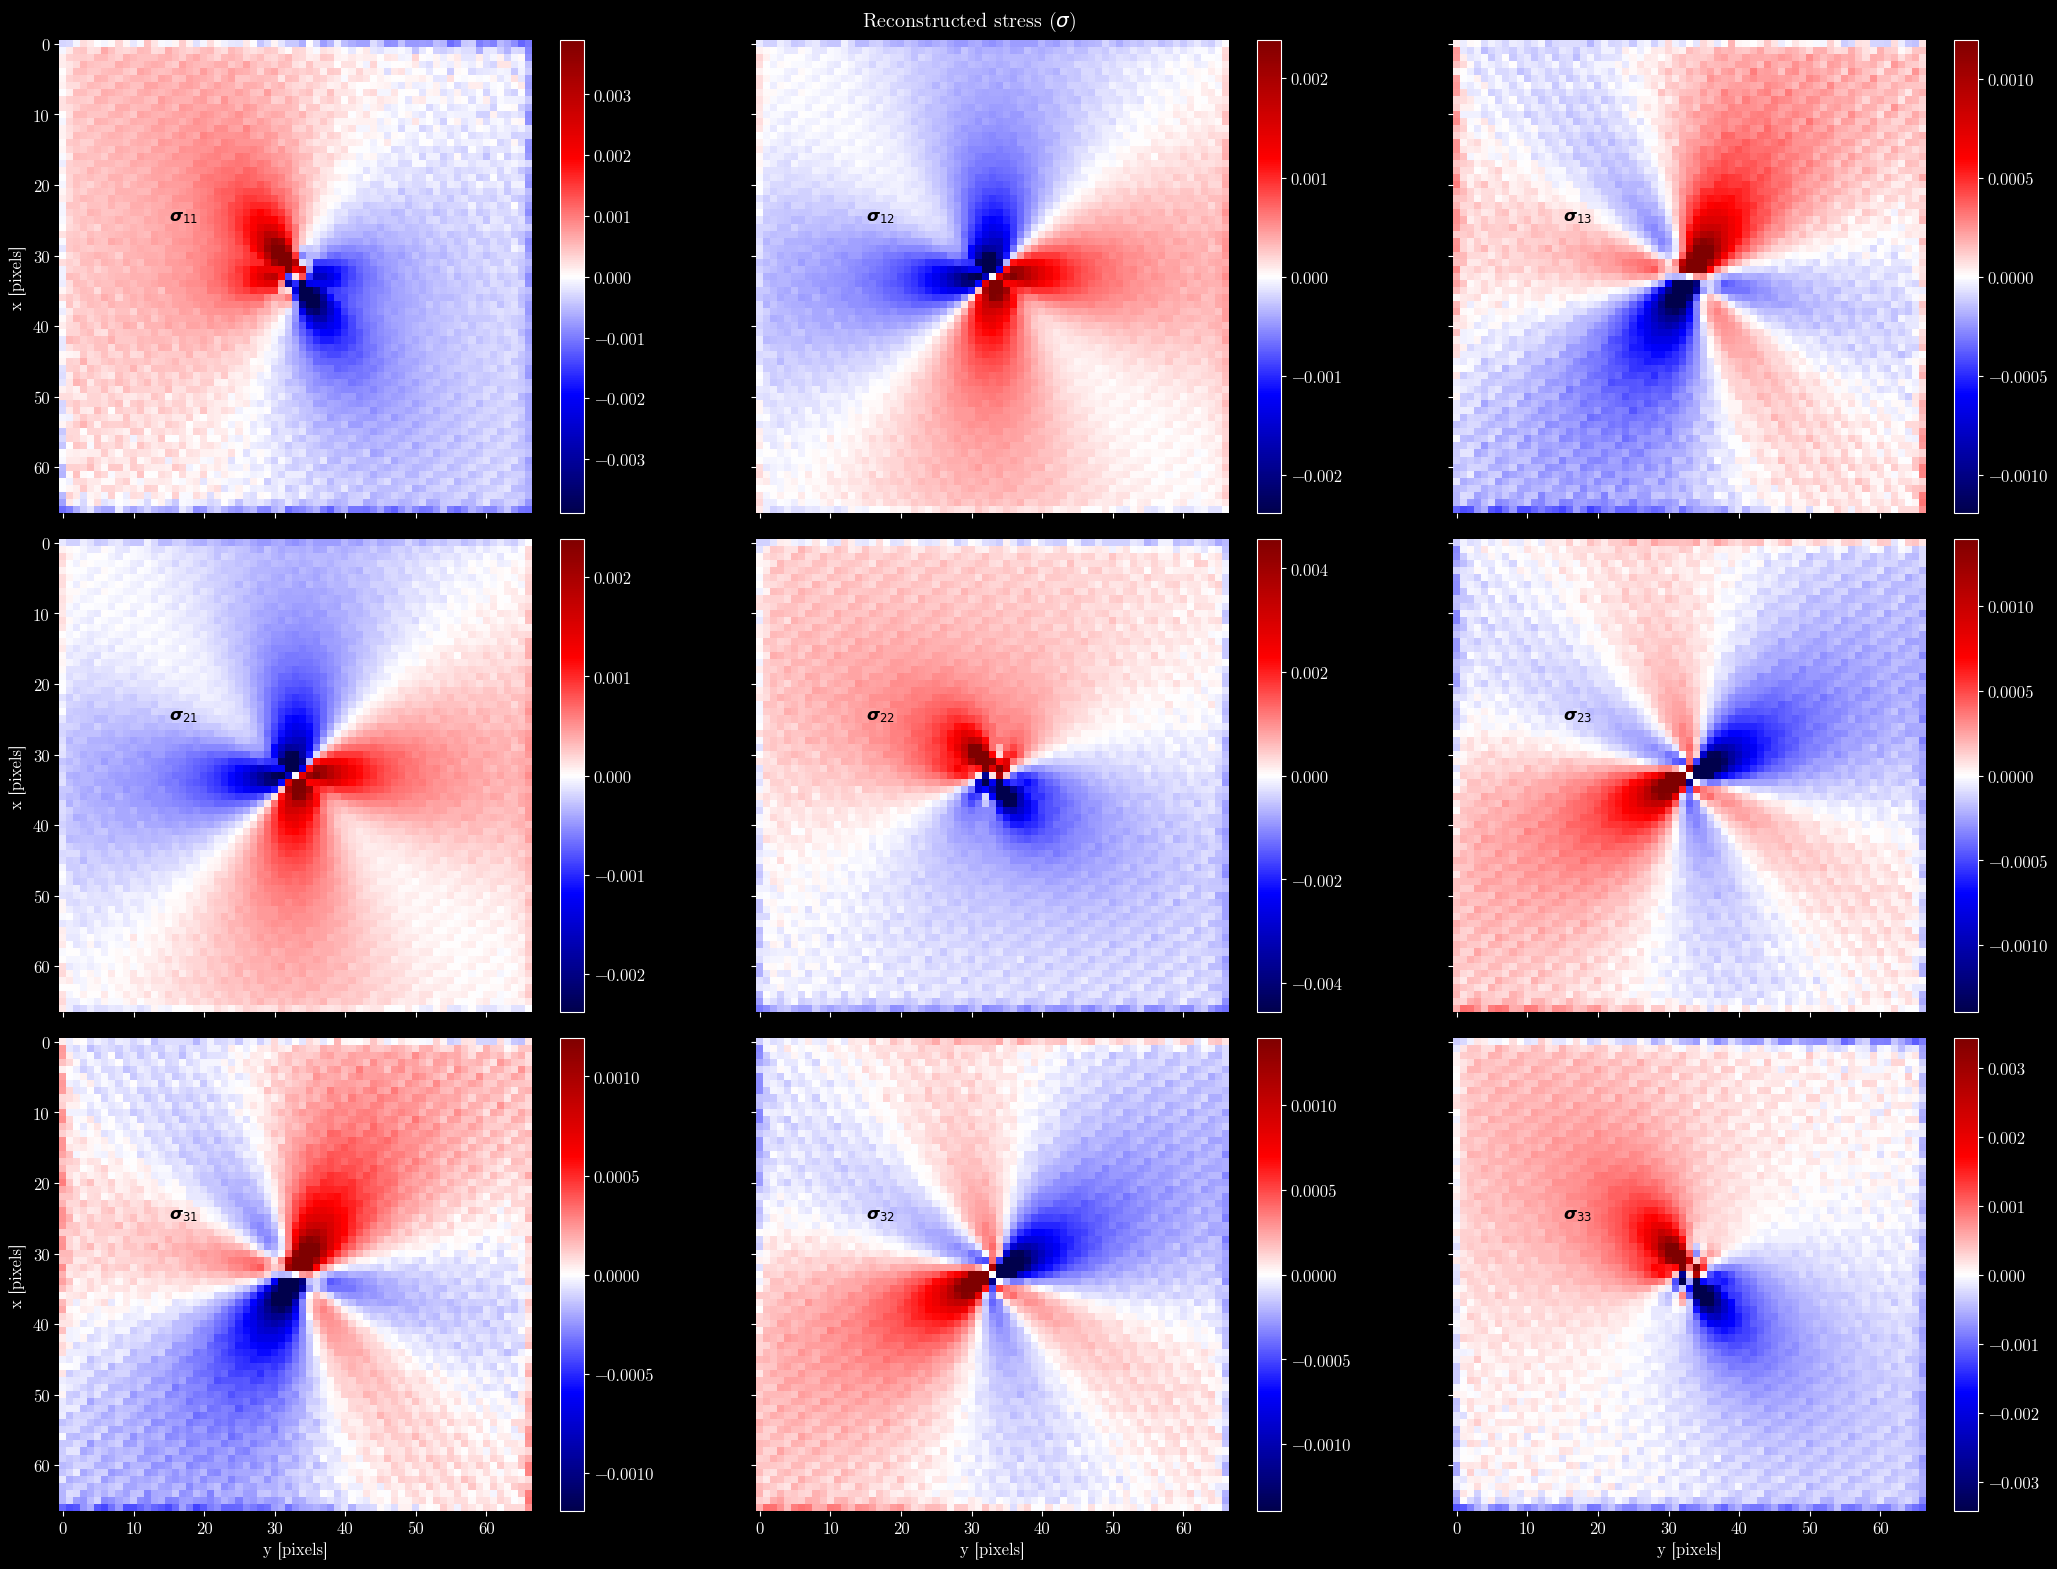

In [174]:
plt.style.use("dark_background")
fig, ax = plt.subplots(3, 3, figsize=(22, 16), sharex=True, sharey=True)
fig.suptitle("Reconstructed stress ($\\sigma$)")
for i in range(3):
    for j in range(3):
        _s = crop(stress[1][:, :, 0, i, j], mask)

        vmax = np.nanmax(np.abs(stress[1][:, :, 0, i, j])) * 0.5
        vmin = -vmax
        im = ax[i, j].imshow(
            _s,
            vmin=vmin,
            vmax=vmax,
            cmap="seismic",
        )
        ax[i, j].annotate(
            r"$\boldsymbol{\sigma}_{" + str(i + 1) + str(j + 1) + r"}$",
            (15, 25),
            c="black",
        )
        fig.colorbar(im, ax=ax[i, j], fraction=0.046, pad=0.04)
        if i == 2:
            ax[i, j].set_xlabel("y [pixels]")
        if j == 0:
            ax[i, j].set_ylabel("x [pixels]")
plt.tight_layout()
for a in ax.flatten():
    for spine in a.spines.values():
        spine.set_visible(False)


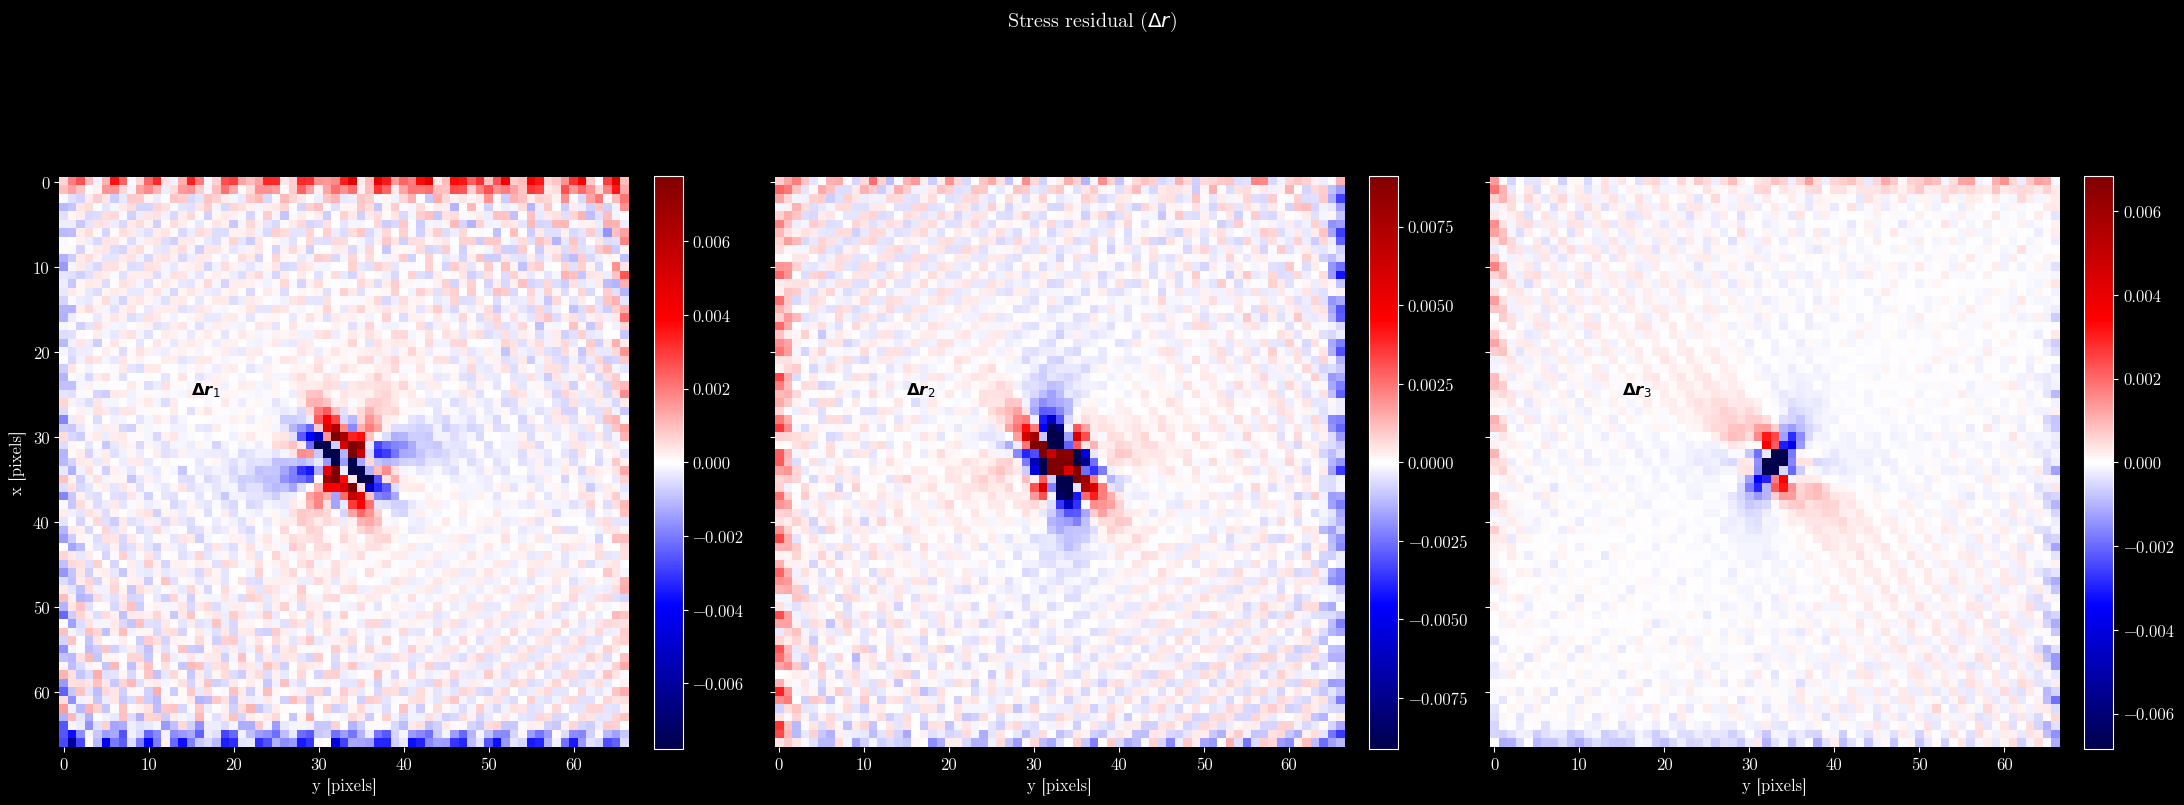

In [175]:
plt.style.use("dark_background")
fig, ax = plt.subplots(1, 3, figsize=(22, 9), sharex=True, sharey=True)
fig.suptitle("Stress residual ($\\Delta r$)")
for i in range(3):
    _s = crop(residual[..., 1, i], mask)

    vmax = np.nanmax(np.abs(stress[1][..., 0, i, :]))
    vmin = -vmax
    im = ax[i].imshow(
        _s,
        vmin=vmin,
        vmax=vmax,
        cmap="seismic",
    )
    ax[i].annotate(
        r"$\boldsymbol{\Delta r}_{" + str(i + 1) + r"}$",
        (15, 25),
        c="black",
    )
    fig.colorbar(im, ax=ax[i], fraction=0.046, pad=0.04)
    ax[i].set_xlabel("y [pixels]")
    if i == 0:
        ax[i].set_ylabel("x [pixels]")
plt.tight_layout()
for a in ax.flatten():
    for spine in a.spines.values():
        spine.set_visible(False)


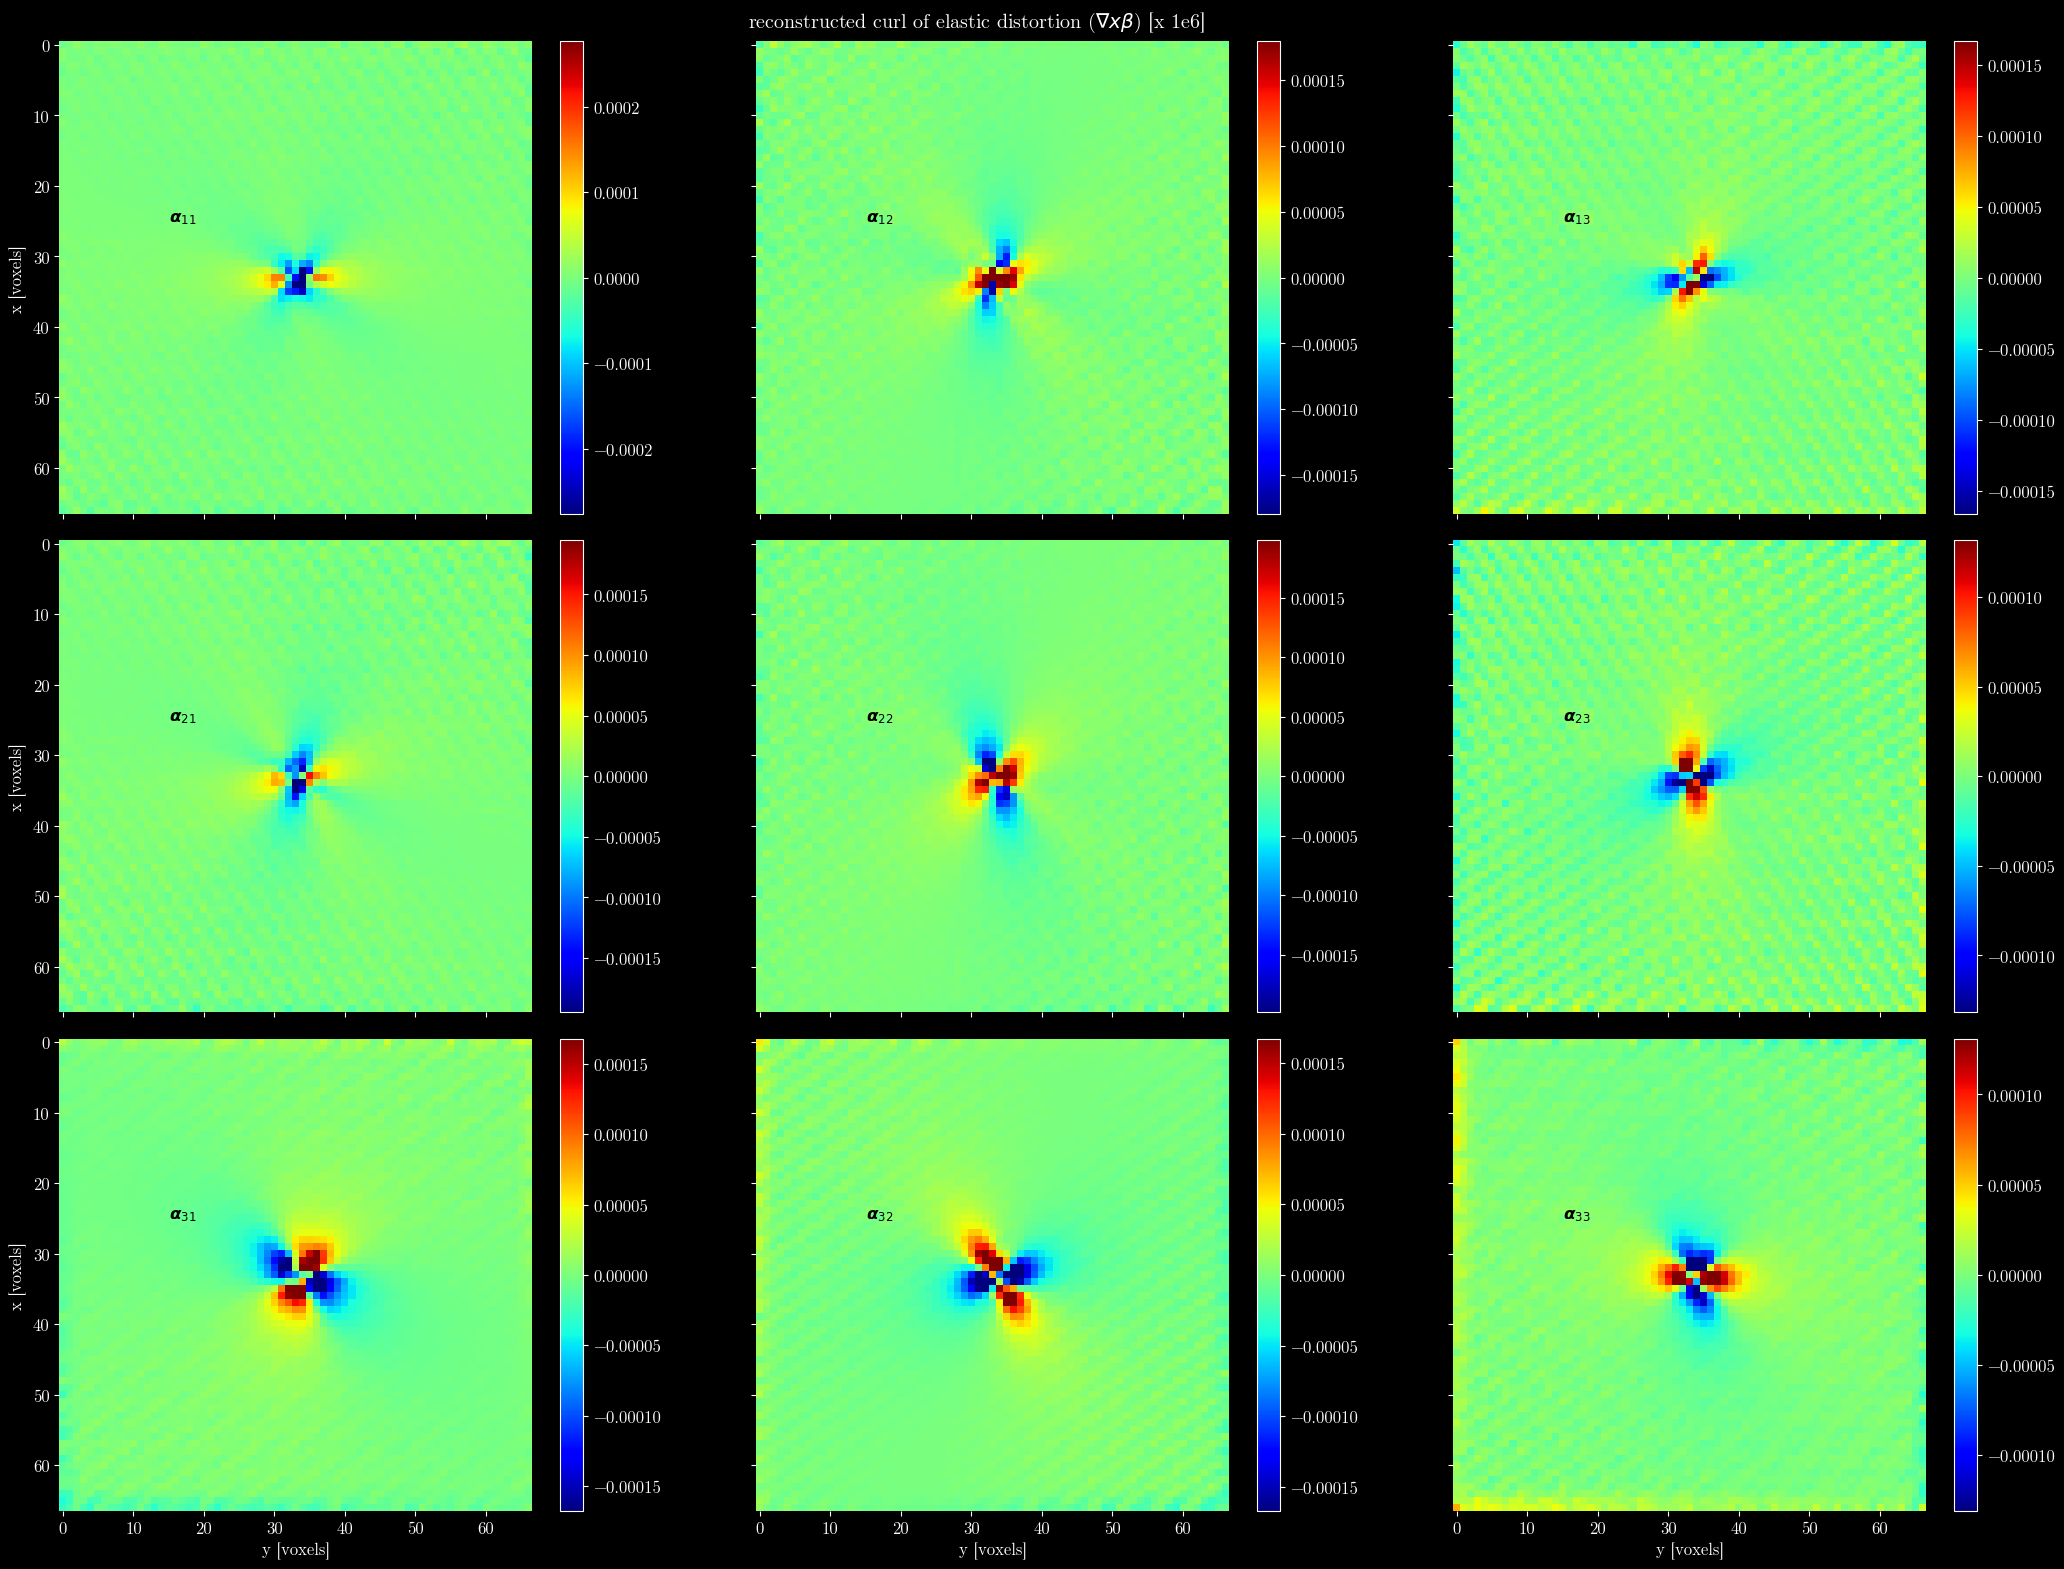

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(22, 16), sharex=True, sharey=True)

_b = np.concatenate([b[:, :, np.newaxis, :, :] for b in betas], axis=2)
curl_beta_rec_3D = curl(_b, (dx, dy, dz))


fig.suptitle("reconstructed curl of elastic distortion ($\\nabla x \\beta$) [x 1e6]")
for i in range(3):
    for j in range(3):
        # _s = crop(beta[:, :, i, j], mask)
        _s = curl_beta_rec_3D[:, :, 0, i, j]

        vmax = np.nanmax(np.abs(_s)) * 0.5
        vmin = -vmax
        im = ax[i, j].imshow(
            _s,
            vmin=vmin,
            vmax=vmax,
            cmap="jet",
        )
        ax[i, j].annotate(
            r"$\boldsymbol{\alpha}_{" + str(i + 1) + str(j + 1) + r"}$",
            (15, 25),
            c="black",
        )
        fig.colorbar(im, ax=ax[i, j], fraction=0.046, pad=0.04)
        if i == 2:
            ax[i, j].set_xlabel("y [voxels]")
        if j == 0:
            ax[i, j].set_ylabel("x [voxels]")
plt.tight_layout()
for a in ax.flatten():
    for spine in a.spines.values():
        spine.set_visible(False)

In [169]:
betas_true[0].shape

(67, 67, 9, 3, 3)

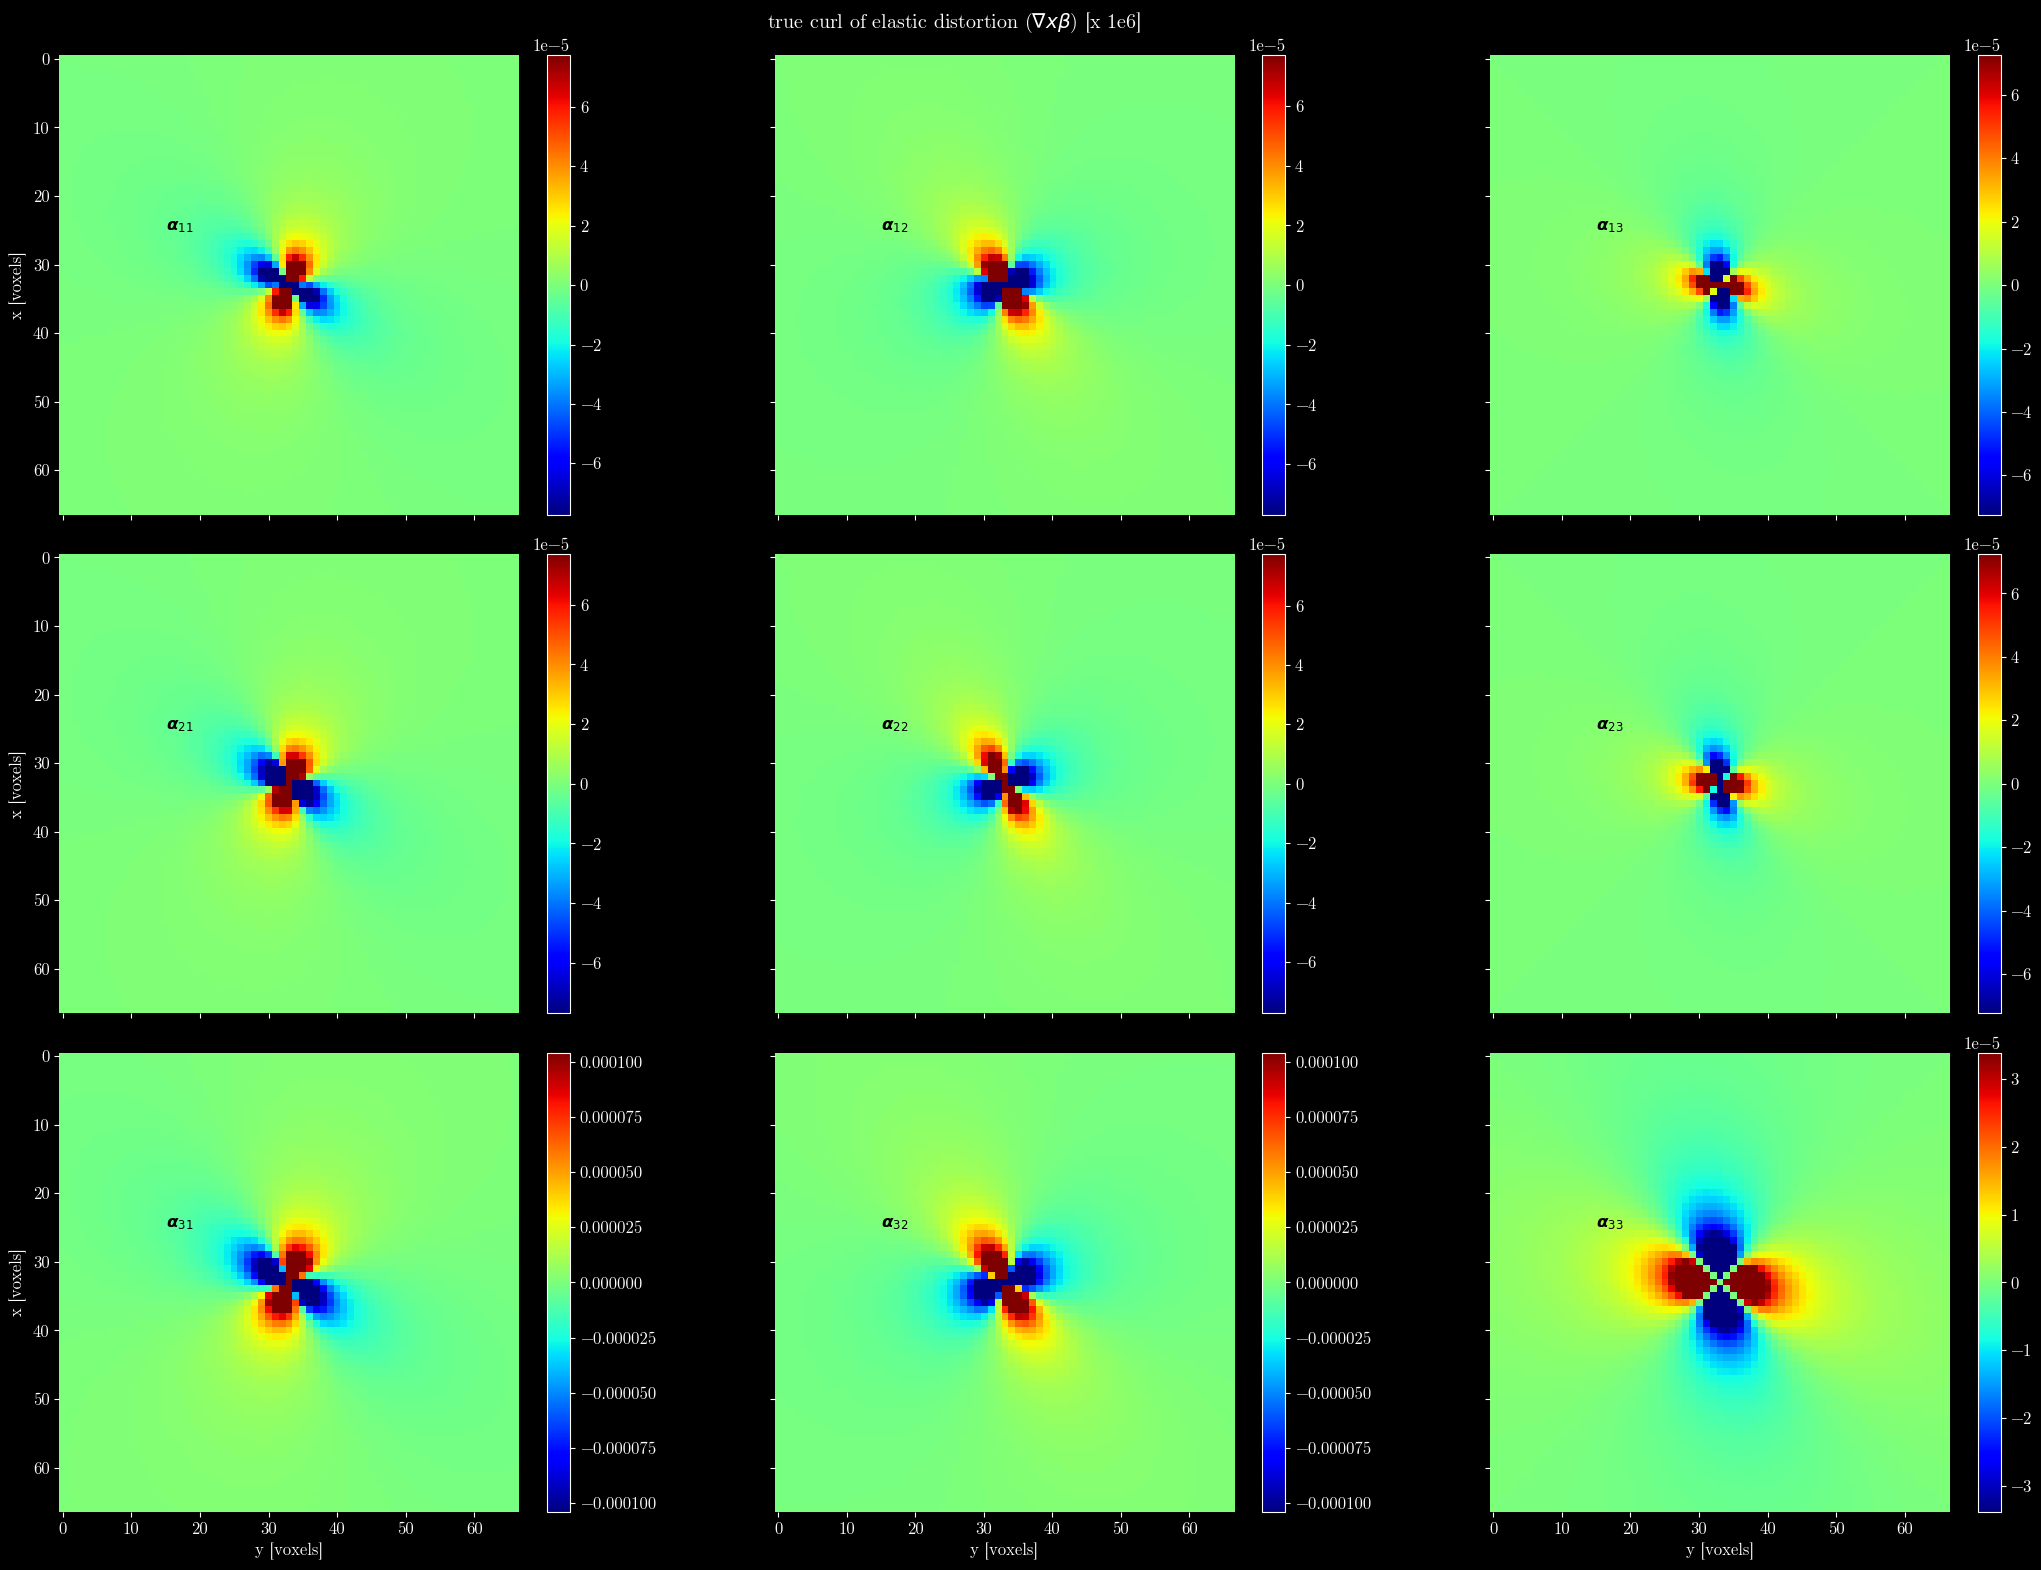

In [170]:
fig, ax = plt.subplots(3, 3, figsize=(22, 16), sharex=True, sharey=True)
_b = betas_true[0]
curl_beta_true_3D = curl(_b, (dx, dy, dz))


fig.suptitle("true curl of elastic distortion ($\\nabla x \\beta$) [x 1e6]")
for i in range(3):
    for j in range(3):
        # _s = crop(beta[:, :, i, j], mask)
        _s = curl_beta_true_3D[:, :, 4, i, j]

        vmax = np.nanmax(np.abs(curl_beta_true_3D[:, :, 4, i, j])) * 0.1
        vmin = -vmax
        im = ax[i, j].imshow(
            _s,
            vmin=vmin,
            vmax=vmax,
            cmap="jet",
        )
        ax[i, j].annotate(
            r"$\boldsymbol{\alpha}_{" + str(i + 1) + str(j + 1) + r"}$",
            (15, 25),
            c="black",
        )
        fig.colorbar(im, ax=ax[i, j], fraction=0.046, pad=0.04)
        if i == 2:
            ax[i, j].set_xlabel("y [voxels]")
        if j == 0:
            ax[i, j].set_ylabel("x [voxels]")
plt.tight_layout()
for a in ax.flatten():
    for spine in a.spines.values():
        spine.set_visible(False)

plt.show()